# Rides

Here we do analysis on all the trip data of Citibikes.

In [1]:
import pandas as pd
import pickle

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import itertools

# settings for plots
from pylab import rcParams
rcParams['figure.figsize'] = 15, 5

## Loading the stations data

In [2]:
class Stations:
    def __init__(self, path):
        self.stations = pickle.load(open(path, "rb"))
       
    # Returns the row that holds information about station that has given station_id
    def get_by_id(self, station_id):
        res = self.stations[self.stations.id == station_id]
        if res.empty:
            raise Exception('Empty Result')
        else:
            return res
    
    # returns all the stations ids as a list
    def get_ids(self):
        return self.stations.id
    
    # returns the head of the table
    def head(self, count=5):
        return self.stations.head(count)
    
    # returns a DataFrame that contain all the unique areas and their respective area_id
    def get_areas(self):
        return self.stations[["area", "area_id"]].drop_duplicates()[:-1]
    
    # returns the entire DataFrame as it is
    def get_stations(self):
        self.stations

In [3]:
stations = Stations("../data/augmented_stations.pickle")

In [4]:
stations.head()

,id,latitude,longitude,stationName,city,neighborhood,neighborhood_id,area,area_id
0,72,40.767272,-73.993929,W 52 St & 11 Ave,New York,All Midtown,119,Midtown West,124
1,79,40.719116,-74.006667,Franklin St & W Broadway,New York,All Downtown,102,Tribeca,105
2,82,40.711174,-74.000165,St James Pl & Pearl St,New York,Chinatown,110,Two Bridges,111
3,83,40.683826,-73.976323,Atlantic Ave & Fort Greene Pl,Brooklyn,Brooklyn,300,Fort Greene,304
4,116,40.741776,-74.001497,W 17 St & 8 Ave,New York,All Downtown,102,Chelsea,115



## Loading Sample Citibike Trip Data

In [5]:
pwd

u'/home/bahuljain/Documents/CitiBike--Analysis/src'

In [12]:
def load_data():    
    trip_data = []
    for i in range(1, 13):
        n = "0" + `i` if i < 10 else str(i)
        trip_data.append(pd.read_csv("../data/trip-data/2015" + n + "-citibike-tripdata.csv"))
    return trip_data

In [14]:
%time trip_data = load_data()

CPU times: user 19.4 s, sys: 2.34 s, total: 21.7 s
Wall time: 21.8 s


In [15]:
trip_data[0].columns

Index([u'tripduration', u'starttime', u'stoptime', u'start station id', u'start station name', u'start station latitude', u'start station longitude', u'end station id', u'end station name', u'end station latitude', u'end station longitude', u'bikeid', u'usertype', u'birth year', u'gender'], dtype='object')

## Obtain the Popular Stations

This includes the number of times a station was either the source or destination in a trip taken.

In [29]:
def trip_stations(trip_data):
    # Number of times a station was the start station. Holds a dict with the station_id
    # as its key and the number of times the station was the starting point of the trip
    # as the value.
    station_outgoing = trip_data.groupby("start station id").size().to_dict()

    # Number of times a station was the end station. Again a dict similar to above.
    station_incoming = trip_data.groupby("end station id").size().to_dict()
    
    return (station_outgoing, station_incoming)

In [17]:
station_out_1, station_in_1 = trip_stations(trip_data_1)

**create an interface to access traffic count in data, given the id**

In [30]:
def get_traffic(data, id):
    return data[id] if id in data else 0

In [21]:
get_traffic(station_out_1, 3002)

1082

**creating final station counts as a python dict**  
**obtaining the popular stations by sorting the dict based on the total traffic at the station**

In [25]:
def get_station_traffic(station_outgoing, station_incoming):
    station_traffic = dict()
    station_flow = {}
    for station_id in stations.get_ids():
        station_traffic[station_id] = get_traffic(station_outgoing, station_id) + \
                                      get_traffic(station_incoming, station_id)
        station_flow[station_id] = get_traffic(station_outgoing, station_id) - \
                                      get_traffic(station_incoming, station_id)
            
    return (station_traffic, sorted(station_traffic.items(), key = lambda (_,v): v, reverse=True), station_flow)

In [72]:
station_traffic, popular_stations, station_flow = get_station_traffic(station_out_1, station_in_1)

In [26]:
def flow_info(station_flow):
    outflow = {}
    inflow = {}
    # seprate influx and outflux
    for k, v in station_flow.items():
        if v > 0:
            outflow[k] = v
        else:
            inflow[k] = v
    outflow = sorted(outflow.items(), key=lambda (_,v): v, reverse=True)
    inflow = sorted(inflow.items(), key=lambda (_,v): v)
    return outflow, inflow

In [88]:
station_outflow, station_inflow = flow_info(station_flow)

In [67]:
def display_station_info(station_traffic, popular_stations, station_outflow, station_inflow):
    for (station_id,_) in popular_stations[:10]:
        info = stations.get_by_id(station_id=station_id)
        station_name = info.stationName.item()
        print `station_id` + ", " + station_name + " : " + `station_traffic[station_id]`
    
    plt.bar(range(len(popular_stations[:20])), [station_traffic[id] for (id,_) in popular_stations[:20]], color='dodgerblue')
    plt.xticks(range(len(popular_stations[:20])), 
           [stations.get_by_id(station_id=id).stationName.item() for (id,_) in popular_stations[:20]], rotation=45)
    plt.title('Total Traffic through Popular Stations')
    plt.show()
    
    max_outflow = station_outflow[:20]
    out_station_names = [stations.get_by_id(station_id=id).stationName.item() for (id, _) in max_outflow]
    plt.bar(range(len(max_outflow)), [v for (_,v) in max_outflow], color='mediumspringgreen')
    plt.xticks(range(len(max_outflow)), out_station_names, rotation=45)
    plt.title('Maximum Outflow Stations')
    plt.show()
    
    max_inflow = station_inflow[:20]
    in_station_names = [stations.get_by_id(station_id=id).stationName.item() for (id,_) in max_inflow]
    plt.bar(range(len(max_inflow)), [v for (_,v) in max_inflow], color='firebrick')
    plt.xticks(range(len(max_inflow)), in_station_names, rotation=60)
    plt.title('Maximum Inflow Stations')
    plt.show()

519, Pershing Square North : 17595
293, Lafayette St & E 8 St : 14353
435, W 21 St & 6 Ave : 13921
497, E 17 St & Broadway : 12865
285, Broadway & E 14 St : 12406
402, Broadway & E 22 St : 11234
490, 8 Ave & W 33 St : 10191
151, Cleveland Pl & Spring St : 9995
368, Carmine St & 6 Ave : 9876
168, W 18 St & 6 Ave : 9783


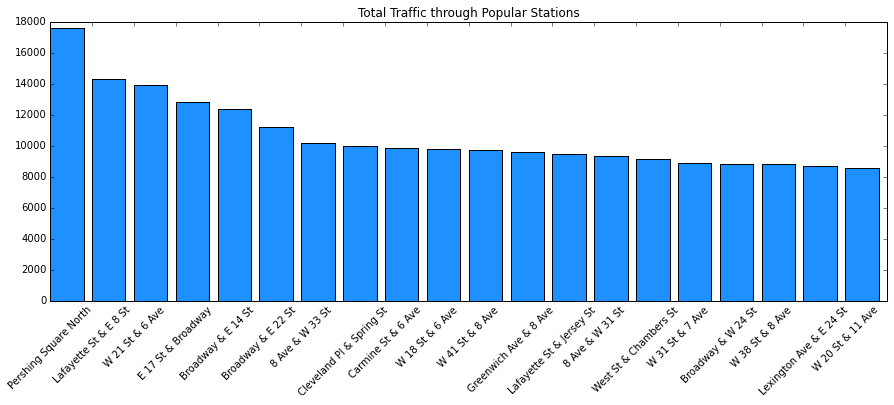

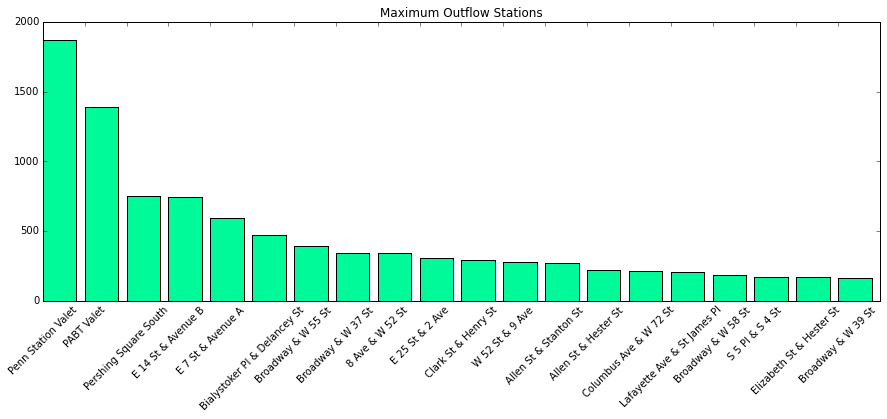

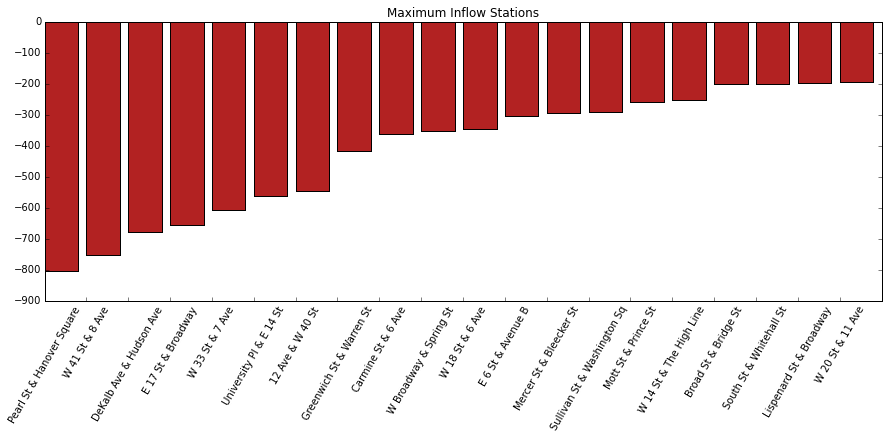

In [68]:
display_station_info(station_traffic, popular_stations, station_outflow, station_inflow)

## Obtain the Popular Areas

In [32]:
areas = stations.get_areas()
areas.head(5)

,area,area_id
0,Midtown West,124
1,Tribeca,105
2,Two Bridges,111
3,Fort Greene,304
4,Chelsea,115


Since we have already found out the traffic at every station, we will use that data to obtain the traffic for every area, which is nothing but the sum of traffic of all the stations in the area.

In [33]:
def get_area_traffic(station_traffic):
    area_traffic = dict()
    for station_id in station_traffic.keys():
        try:
            info = stations.get_by_id(station_id)
            area_id = info.area_id.item()

            if area_id not in area_traffic:
                area_traffic[area_id] = station_traffic[station_id]
            else:
                area_traffic[area_id] += station_traffic[station_id] 
        except:
            pass
    
    return area_traffic

In [34]:
def get_area_traffic_stations(station_outgoing, station_incoming):
    area_outgoing = get_area_traffic(station_outgoing)
    area_incoming = get_area_traffic(station_incoming)
    return area_outgoing, area_incoming

In [40]:
area_outgoing, area_incoming = get_area_traffic_stations(station_out_1, station_in_1)

In [35]:
def total_area_traffic(area_outgoing, area_incoming):
    area_traffic = dict()
    area_flow = {}
    for area_id in areas.area_id:
        area_traffic[area_id] = get_traffic(area_incoming, area_id) + \
                                get_traffic(area_outgoing, area_id)
        area_flow[area_id] = get_traffic(area_outgoing, area_id) - \
                                get_traffic(area_incoming, area_id)
    return area_traffic, area_flow

In [46]:
area_traffic_1, area_flow_1 = total_area_traffic(area_outgoing, area_incoming)

In [36]:
def get_popular_areas(area_traffic):
    return sorted(area_traffic.items(), key=lambda (_, v): v, reverse=True)

In [57]:
popular_areas = get_popular_areas(area_traffic_1)

In [37]:
def flow_info(area_flow):
    outflow = {}
    inflow = {}
    # seprate influx and outflux
    for k, v in area_flow.items():
        if v > 0:
            outflow[k] = v
        else:
            inflow[k] = v
    outflow = sorted(outflow.items(), key=lambda (_,v): v, reverse=True)
    inflow = sorted(inflow.items(), key=lambda (_,v): v)
    return outflow, inflow

In [52]:
outflow, inflow = flow_info(area_flow_1)

In [53]:
outflow

[(120, 980),
 (130, 766),
 (113, 677),
 (122, 635),
 (124, 514),
 (303, 318),
 (305, 241),
 (157, 217),
 (364, 132),
 (106, 101),
 (121, 62),
 (114, 55),
 (310, 13),
 (132, 12),
 (136, 3)]

In [56]:
def display_popular_areas(popular_areas):
    for area_id,_ in popular_areas[:10]:
        info = areas[areas.area_id == area_id]
        area_name = info.area.item()
        print area_id, area_name, area_traffic[area_id]
    area_names = [areas[areas.area_id == id].area.item() for (id,_) in popular_areas]
    
    most_popular_areas = popular_areas[:20]
    most_popular_area_names = area_names[:20]
    plt.bar(range(len(most_popular_areas)), [v for (_,v) in most_popular_areas], color='darkblue')
    plt.xticks(range(len(most_popular_area_names)), most_popular_area_names, rotation=45)
    plt.title('Total Traffic Through Most Popular Areas')
    plt.show()
    
    max_outflow = outflow[:20]
    out_area_names = [areas[areas.area_id == id].area.item() for (id,_) in max_outflow]
    plt.bar(range(len(max_outflow)), [v for (_,v) in max_outflow], color='mediumaquamarine')
    plt.xticks(range(len(max_outflow)), out_area_names, rotation=45)
    plt.title('Maximum Outflow Areas')
    plt.show()
    
    max_inflow = inflow[:20]
    in_area_names = [areas[areas.area_id == id].area.item() for (id,_) in max_inflow]
    plt.bar(range(len(max_inflow)), [v for (_,v) in max_inflow], color='crimson')
    plt.xticks(range(len(max_inflow)), in_area_names, rotation=60)
    plt.title('Maximum Inflow Areas')
    plt.show()

117 East Village 123388
124 Midtown West 109942
120 Midtown 106647
115 Chelsea 88632
122 Midtown South 84259
116 Greenwich Village 76167
157 West Village 68637
158 Flatiron 62234
109 Lower East Side 56496
105 Tribeca 49332


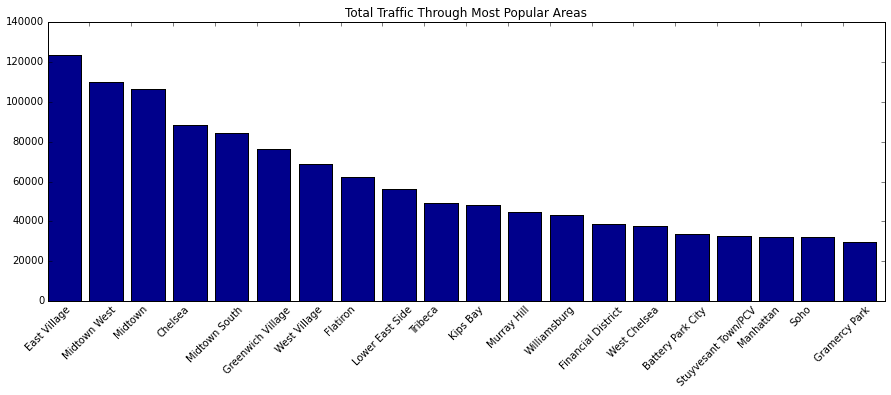

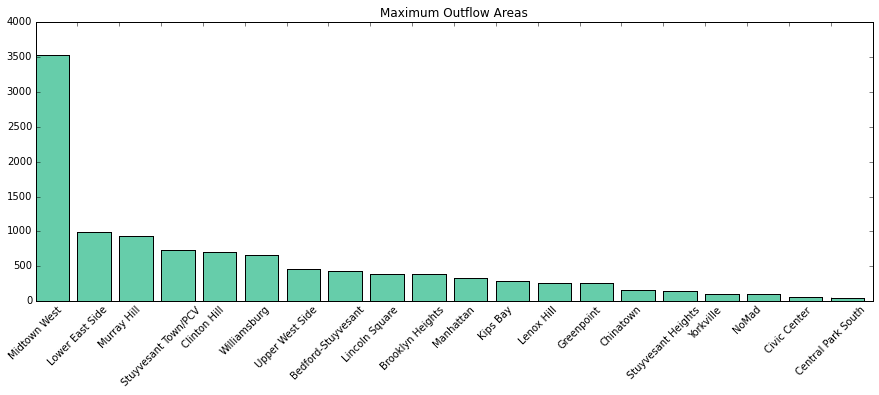

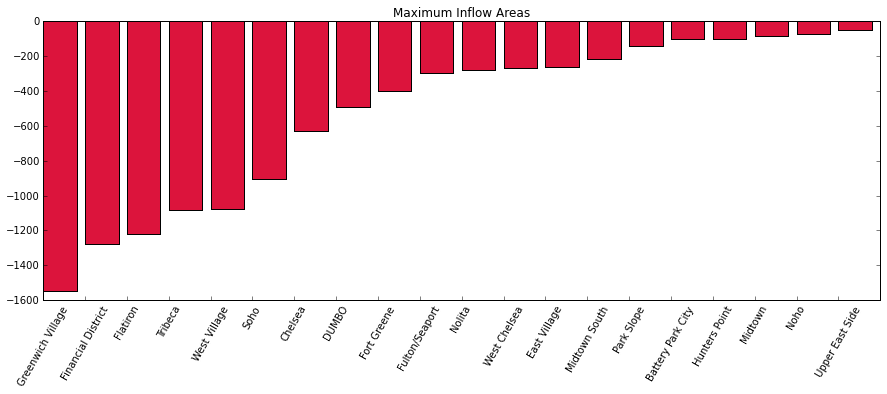

In [57]:
display_popular_areas(popular_areas)

## Popular Areas by Month:

In [69]:
import calendar

Month:  January 

521, 8 Ave & W 31 St : 7476
293, Lafayette St & E 8 St : 6314
435, W 21 St & 6 Ave : 5965
477, W 41 St & 8 Ave : 5692
497, E 17 St & Broadway : 5471
379, W 31 St & 7 Ave : 5102
490, 8 Ave & W 33 St : 5018
519, Pershing Square North : 4586
492, W 33 St & 7 Ave : 4540
285, Broadway & E 14 St : 4430


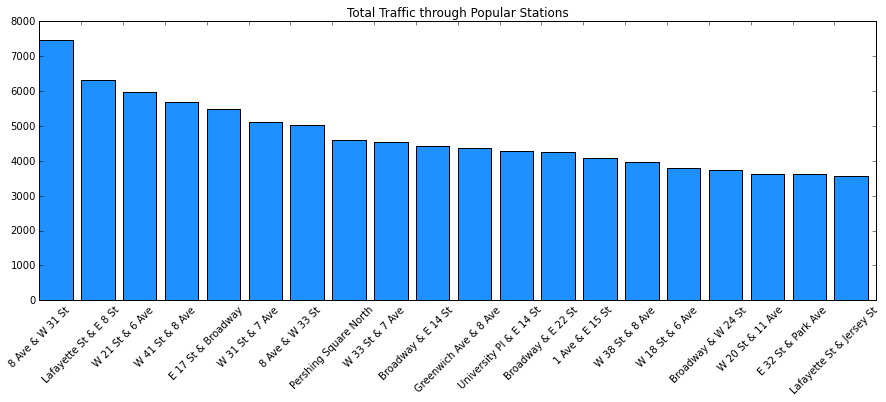

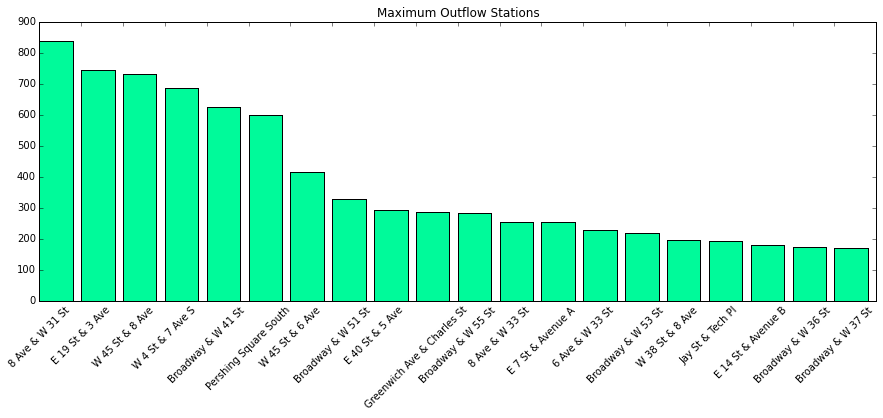

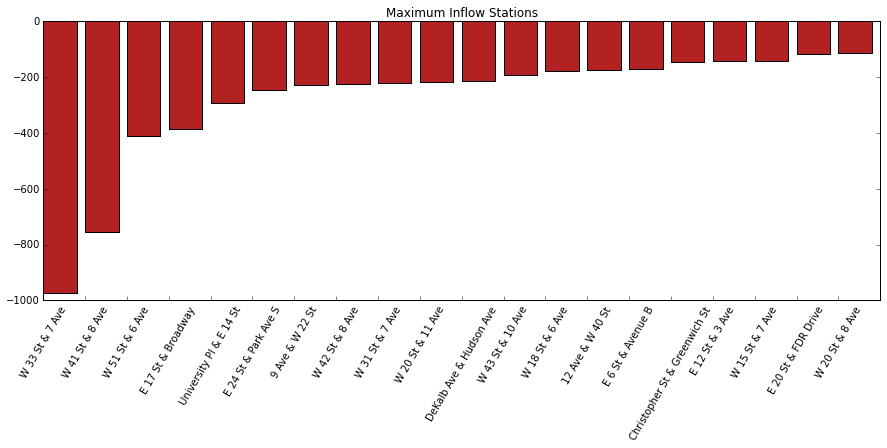

117 East Village 52723
124 Midtown West 42846
122 Midtown South 40257
120 Midtown 38560
115 Chelsea 36236
116 Greenwich Village 27631
158 Flatiron 25748
109 Lower East Side 25073
157 West Village 22379
133 Kips Bay 22265


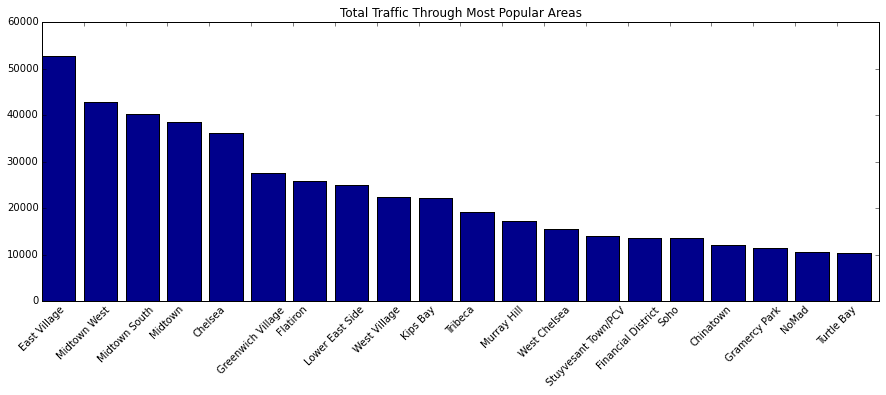

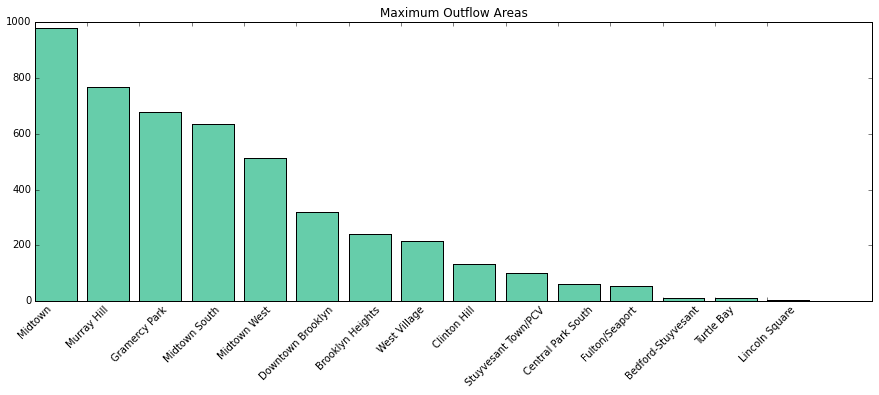

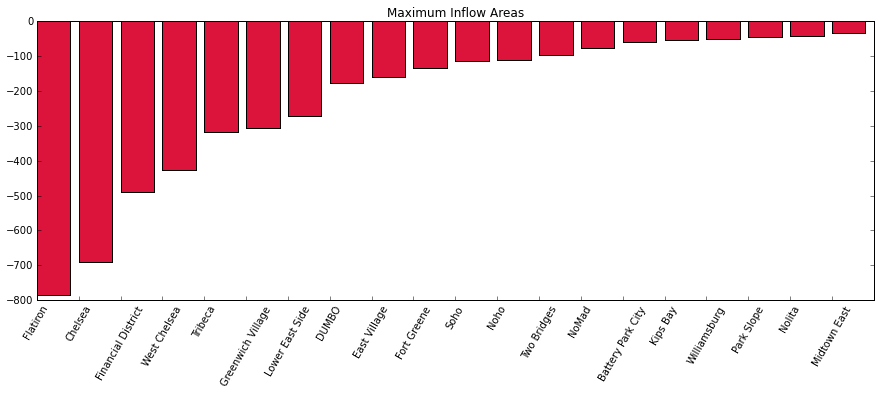

Month:  February 

477, W 41 St & 8 Ave : 4626
293, Lafayette St & E 8 St : 4374
435, W 21 St & 6 Ave : 4364
521, 8 Ave & W 31 St : 4191
497, E 17 St & Broadway : 3898
379, W 31 St & 7 Ave : 3836
490, 8 Ave & W 33 St : 3756
492, W 33 St & 7 Ave : 3388
537, Lexington Ave & E 24 St : 3347
504, 1 Ave & E 15 St : 3253


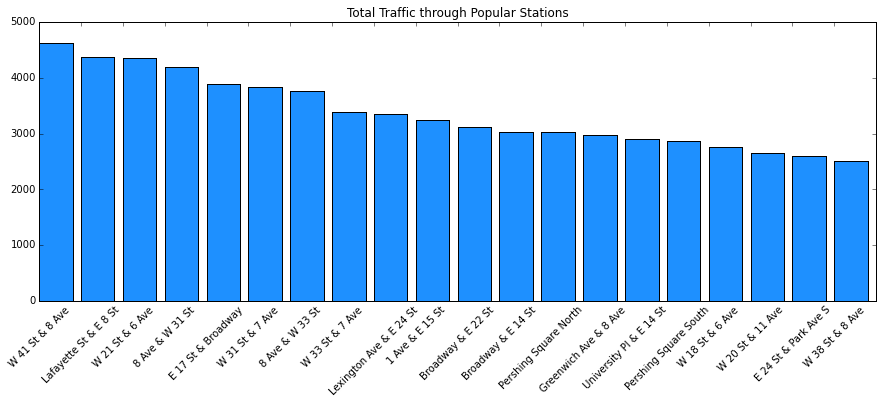

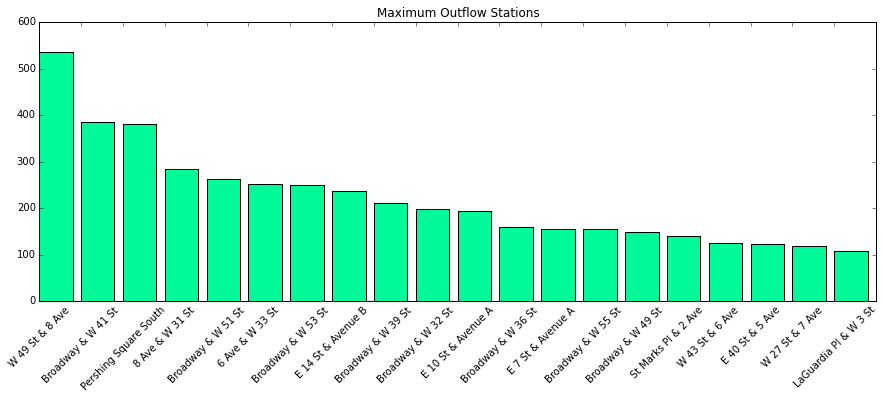

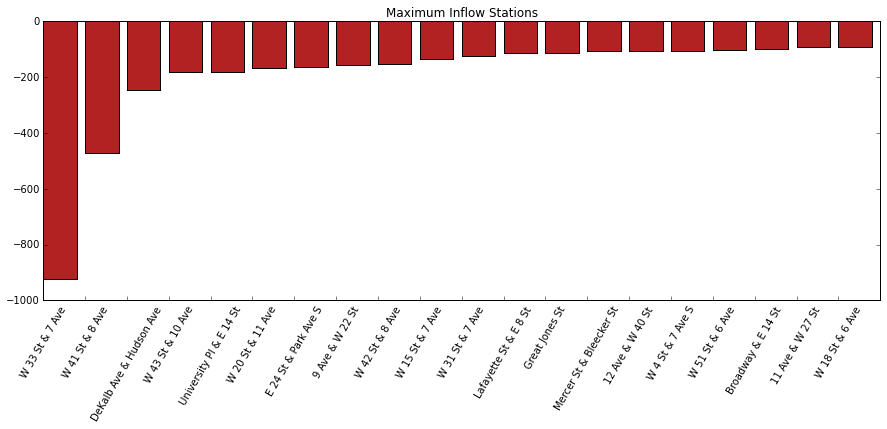

117 East Village 38468
124 Midtown West 28167
122 Midtown South 27726
120 Midtown 26233
115 Chelsea 25370
116 Greenwich Village 20211
109 Lower East Side 18281
158 Flatiron 18270
133 Kips Bay 15920
157 West Village 15701


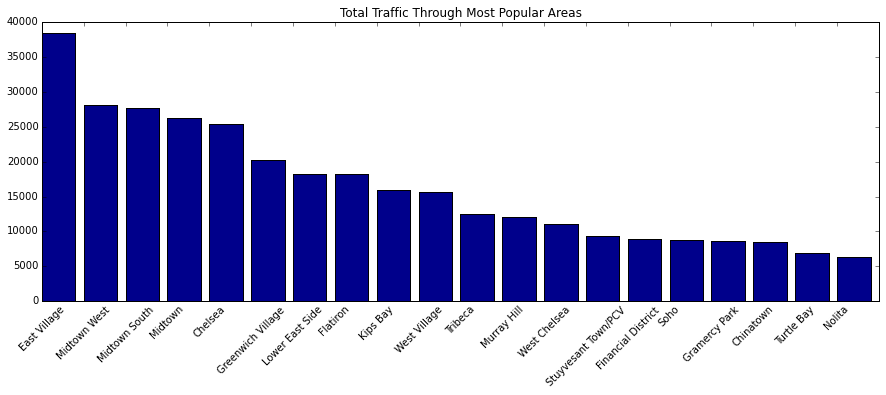

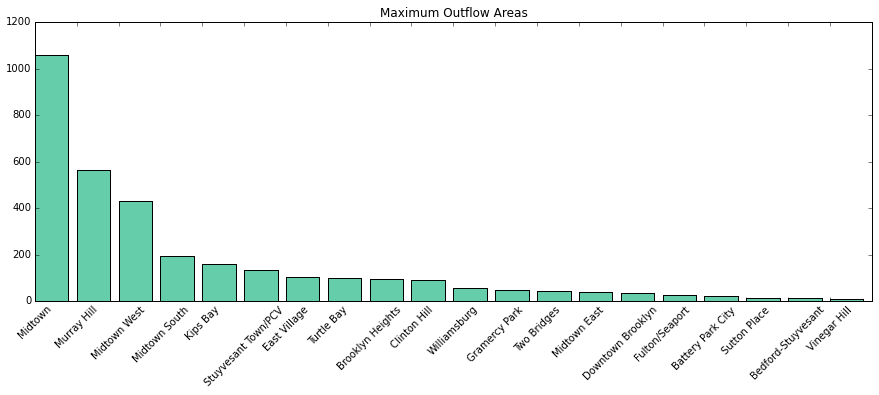

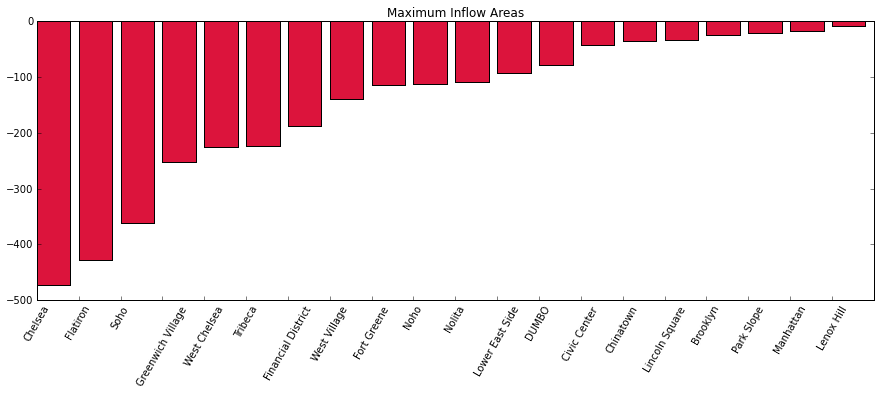

Month:  March 

490, 8 Ave & W 33 St : 10992
293, Lafayette St & E 8 St : 7340
435, W 21 St & 6 Ave : 6669
477, W 41 St & 8 Ave : 6635
379, W 31 St & 7 Ave : 6587
497, E 17 St & Broadway : 6467
537, Lexington Ave & E 24 St : 6302
519, Pershing Square North : 6296
402, Broadway & E 22 St : 5236
285, Broadway & E 14 St : 5060


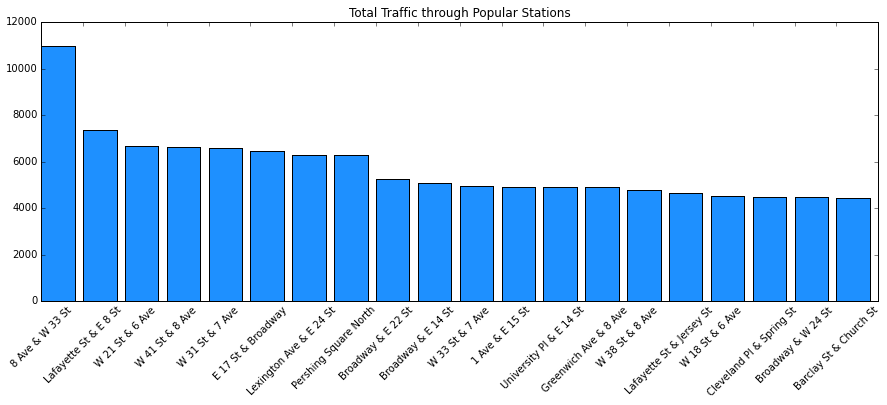

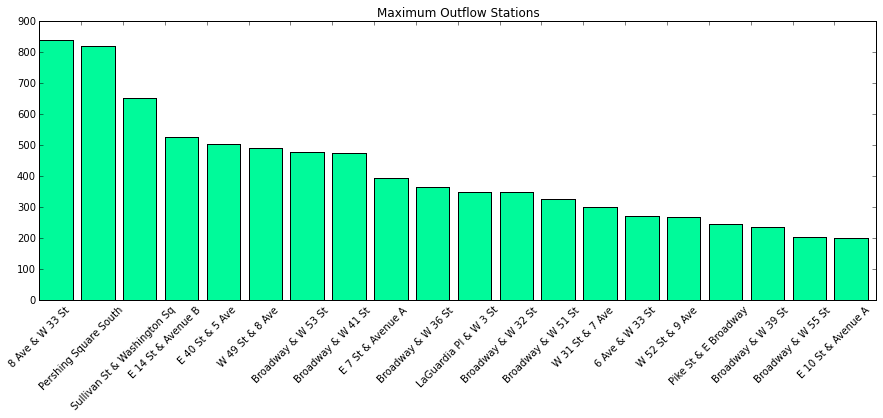

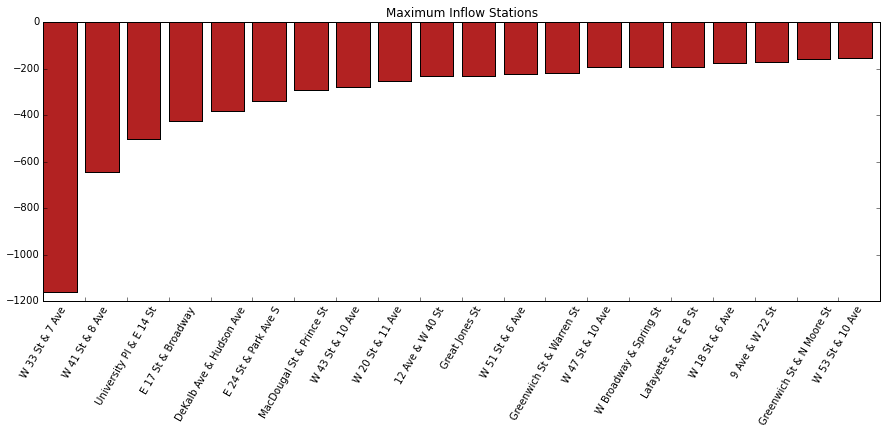

117 East Village 63345
122 Midtown South 52431
120 Midtown 45909
124 Midtown West 44966
115 Chelsea 41783
116 Greenwich Village 32568
158 Flatiron 31050
109 Lower East Side 29607
157 West Village 28171
133 Kips Bay 27239


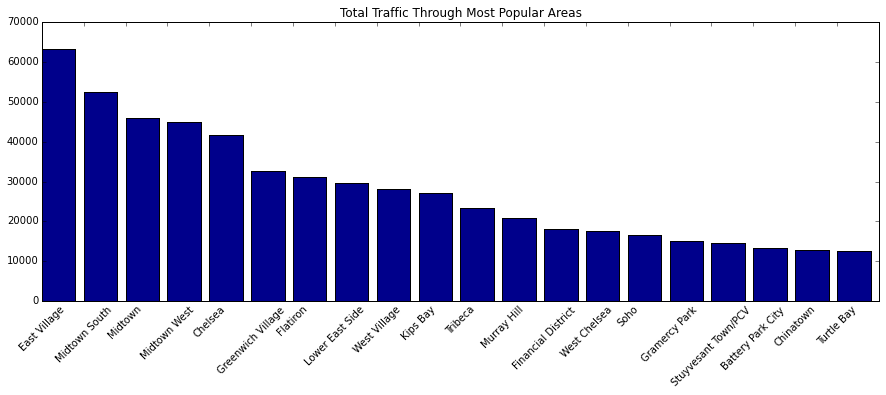

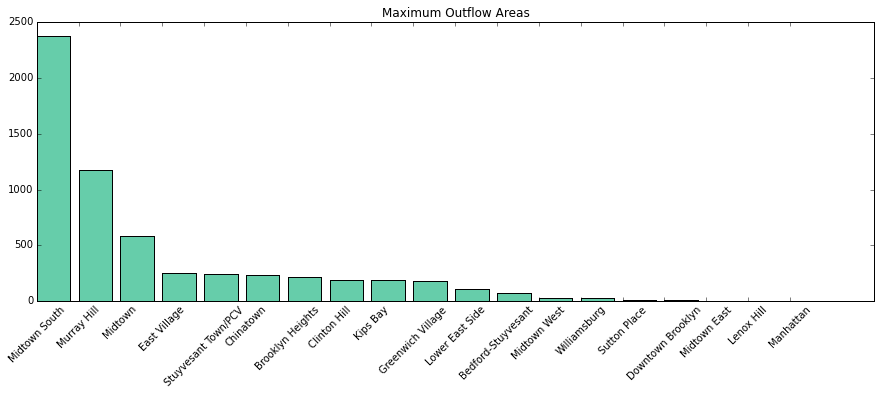

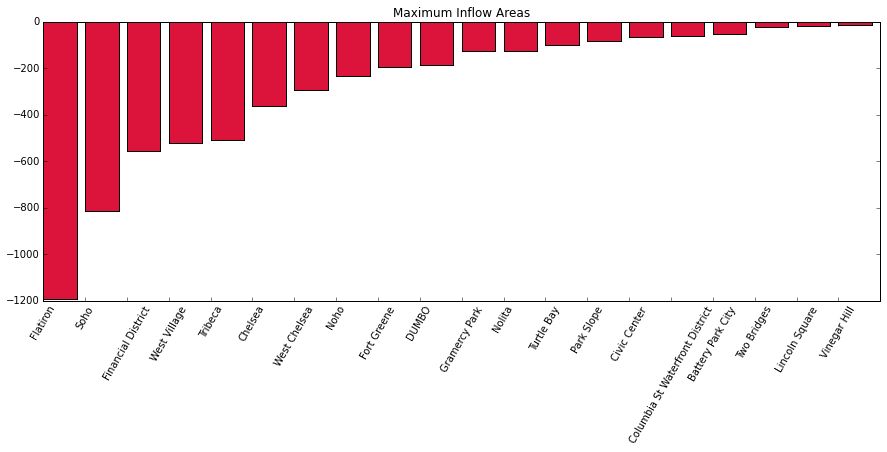

Month:  April 

293, Lafayette St & E 8 St : 13683
521, 8 Ave & W 31 St : 13160
497, E 17 St & Broadway : 12752
435, W 21 St & 6 Ave : 12703
519, Pershing Square North : 11282
426, West St & Chambers St : 10592
151, Cleveland Pl & Spring St : 10186
499, Broadway & W 60 St : 9909
285, Broadway & E 14 St : 9901
284, Greenwich Ave & 8 Ave : 9893


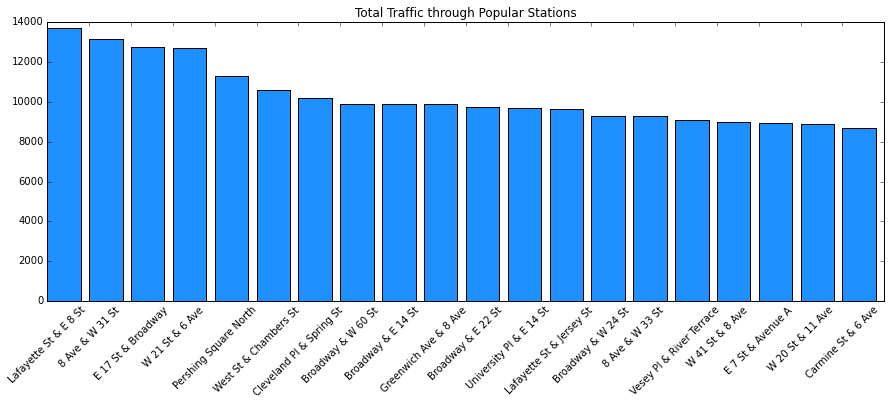

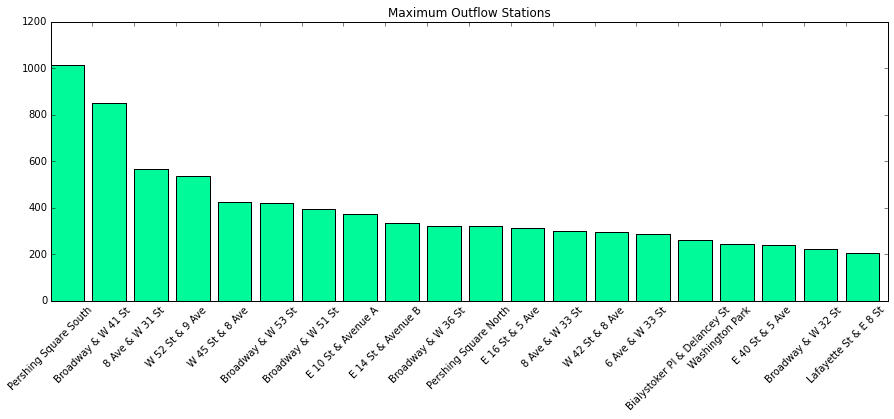

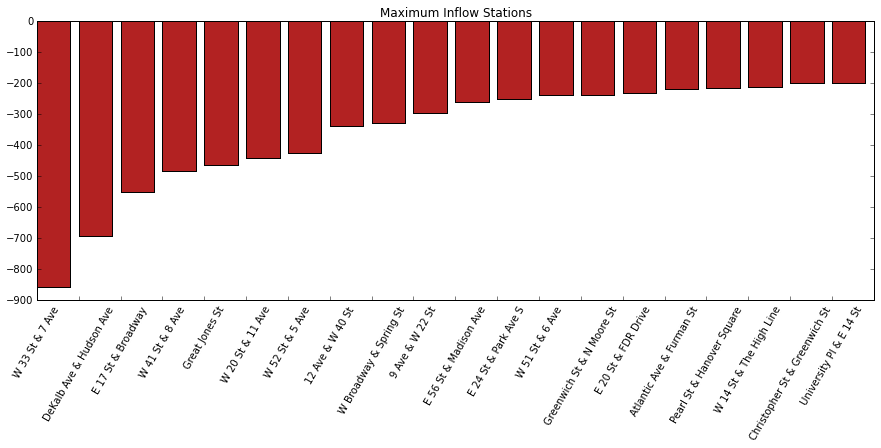

117 East Village 117053
124 Midtown West 99402
115 Chelsea 79247
120 Midtown 76656
122 Midtown South 73935
116 Greenwich Village 69232
157 West Village 62411
158 Flatiron 56823
109 Lower East Side 55406
105 Tribeca 46112


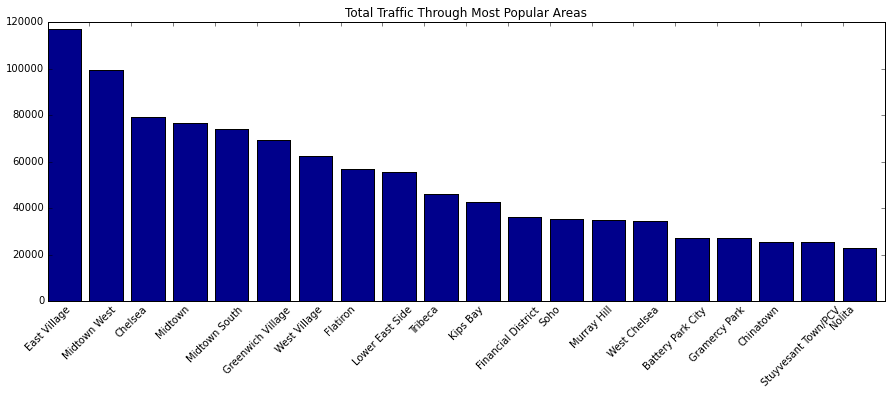

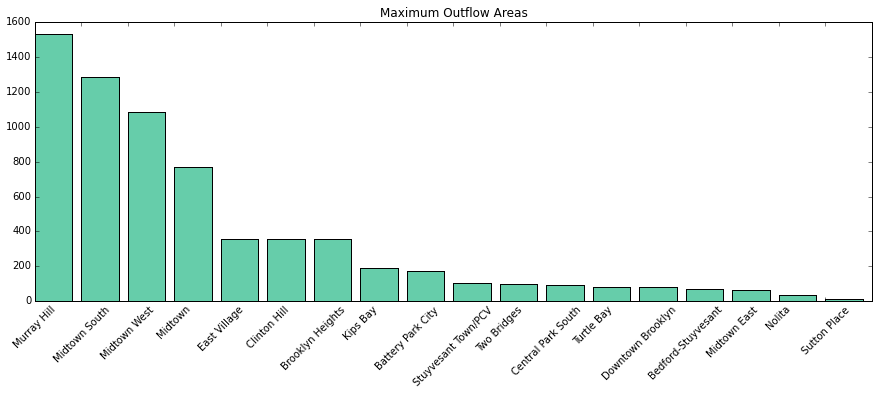

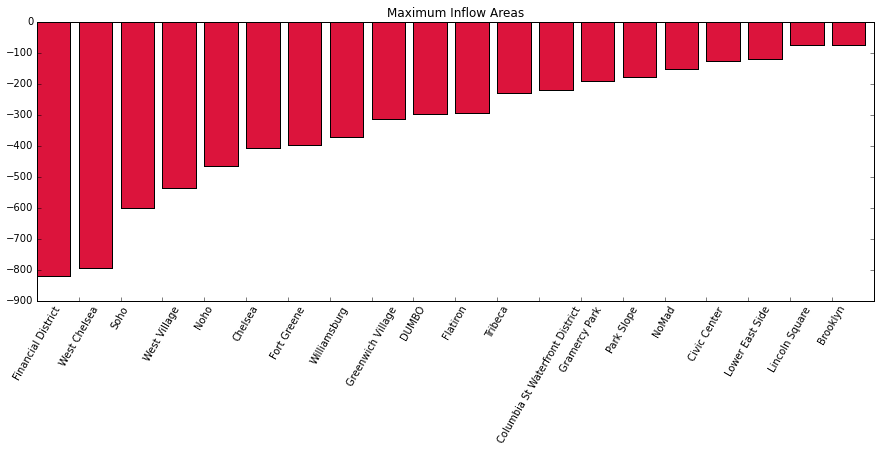

Month:  May 

521, 8 Ave & W 31 St : 22819
519, Pershing Square North : 20459
293, Lafayette St & E 8 St : 20160
426, West St & Chambers St : 19556
497, E 17 St & Broadway : 19410
435, W 21 St & 6 Ave : 18779
499, Broadway & W 60 St : 16586
127, Barrow St & Hudson St : 15160
327, Vesey Pl & River Terrace : 15150
284, Greenwich Ave & 8 Ave : 14984


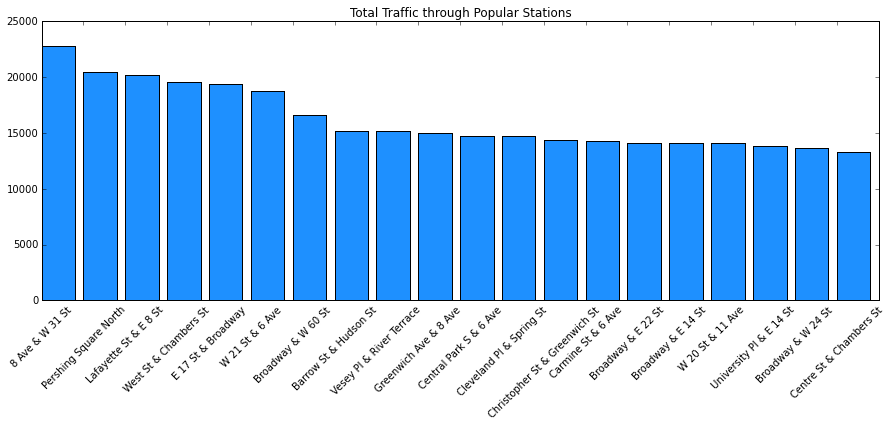

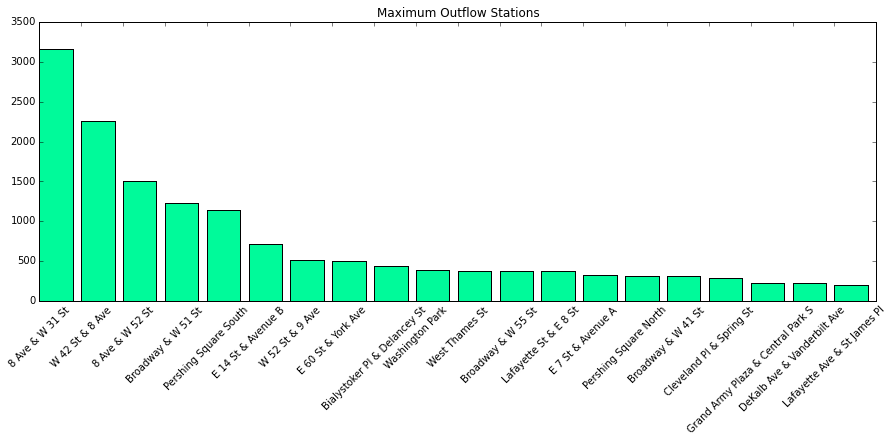

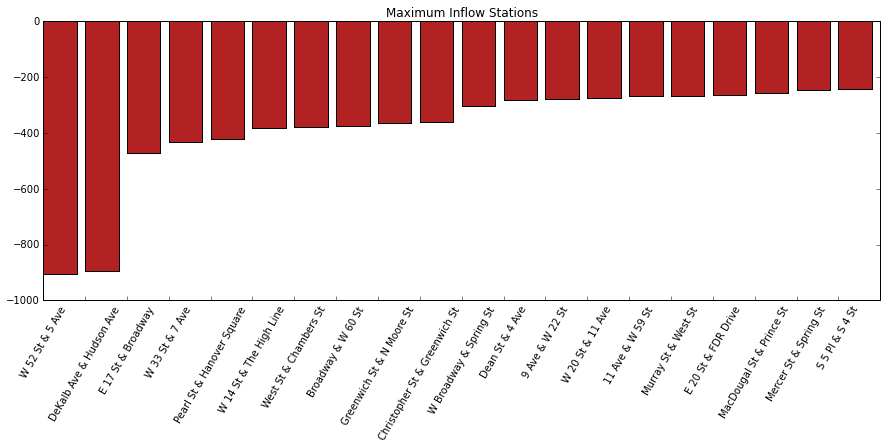

117 East Village 168429
124 Midtown West 151909
115 Chelsea 117088
157 West Village 108532
120 Midtown 107890
116 Greenwich Village 101072
122 Midtown South 100193
109 Lower East Side 82147
158 Flatiron 76608
105 Tribeca 70481


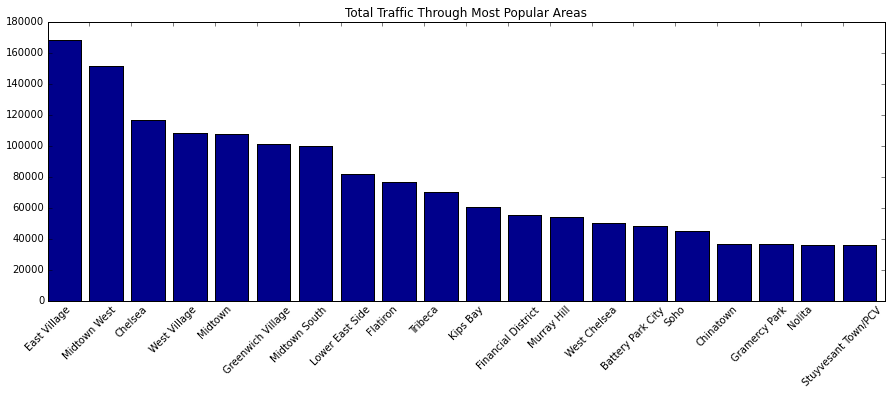

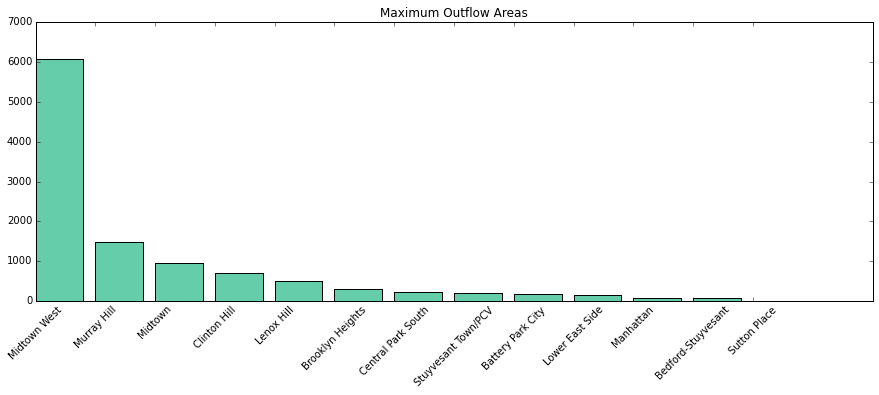

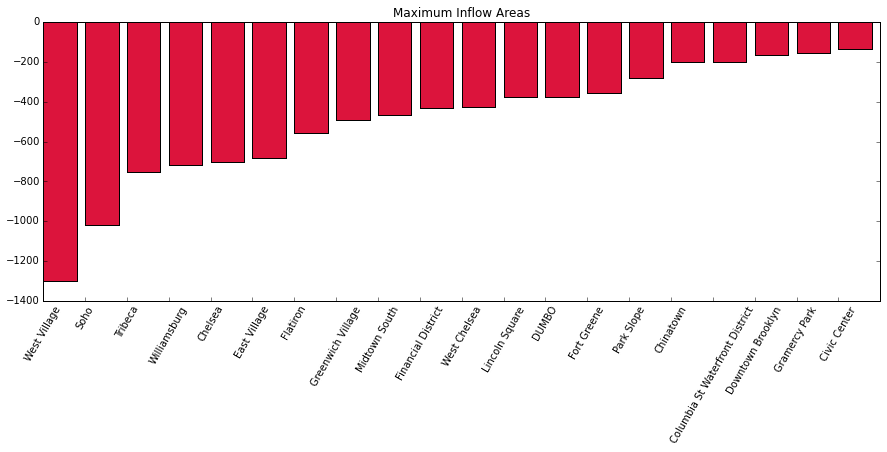

Month:  June 

521, 8 Ave & W 31 St : 23345
519, Pershing Square North : 21746
293, Lafayette St & E 8 St : 19031
497, E 17 St & Broadway : 18175
426, West St & Chambers St : 18016
435, W 21 St & 6 Ave : 17123
127, Barrow St & Hudson St : 14694
284, Greenwich Ave & 8 Ave : 14447
285, Broadway & E 14 St : 14422
327, Vesey Pl & River Terrace : 14228


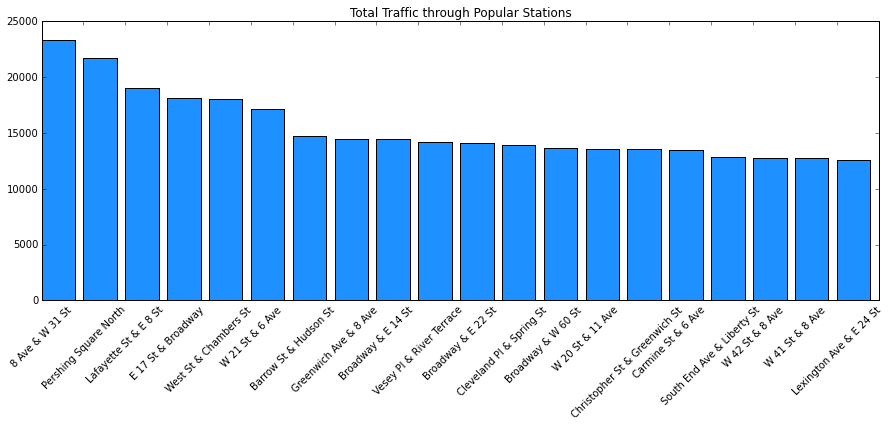

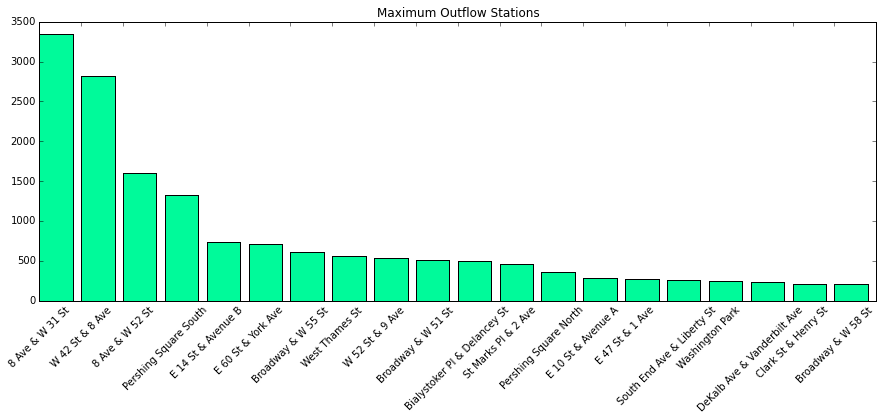

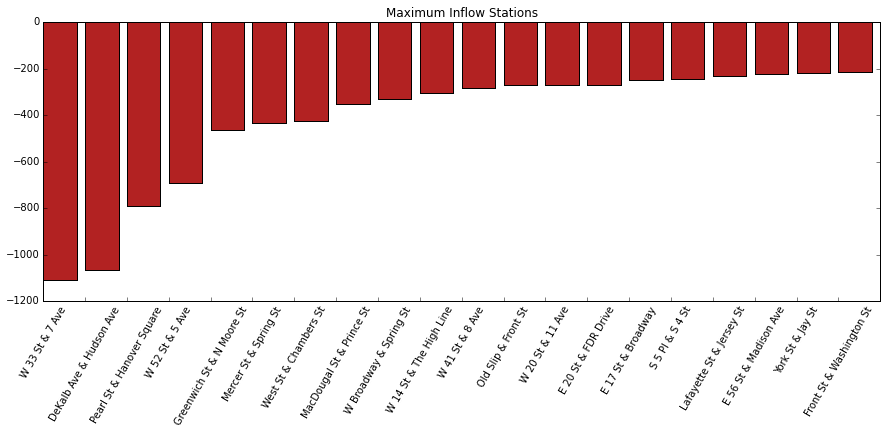

117 East Village 161873
124 Midtown West 148766
115 Chelsea 117946
120 Midtown 106368
122 Midtown South 103254
157 West Village 101303
116 Greenwich Village 96978
158 Flatiron 81311
109 Lower East Side 78345
105 Tribeca 73408


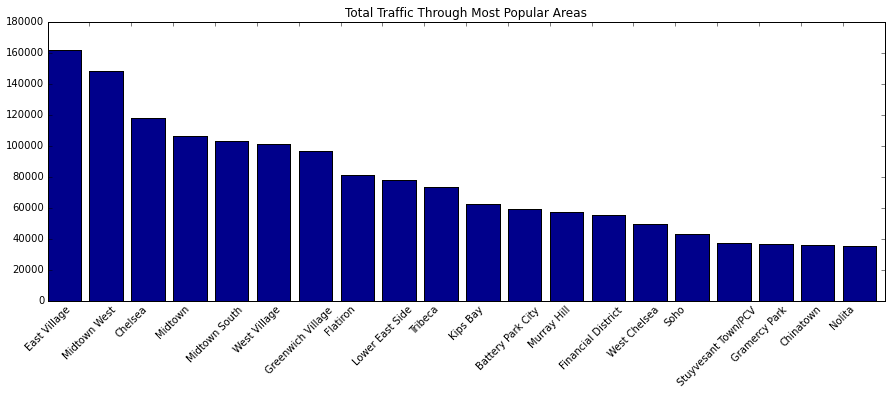

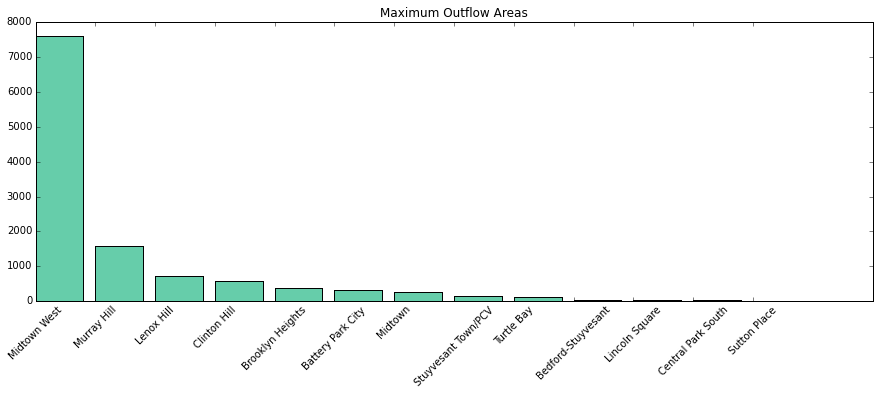

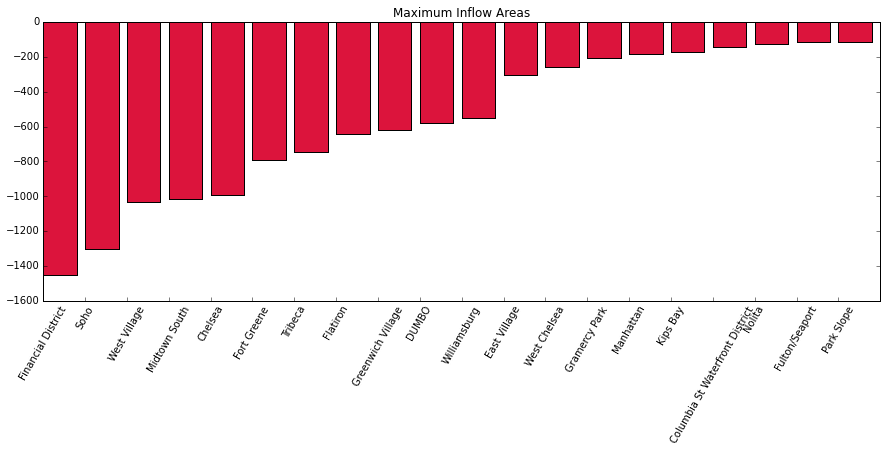

Month:  July 

521, 8 Ave & W 31 St : 25883
519, Pershing Square North : 23220
426, West St & Chambers St : 22482
293, Lafayette St & E 8 St : 20698
497, E 17 St & Broadway : 20181
435, W 21 St & 6 Ave : 18477
499, Broadway & W 60 St : 17435
327, Vesey Pl & River Terrace : 17115
285, Broadway & E 14 St : 16355
3002, South End Ave & Liberty St : 16181


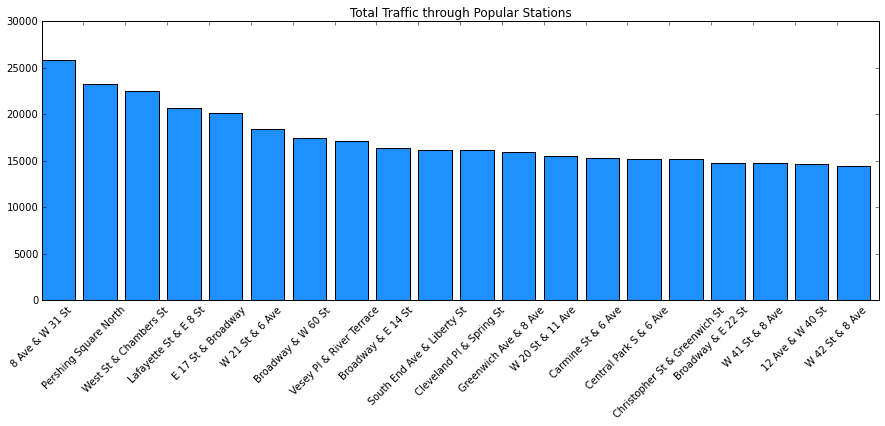

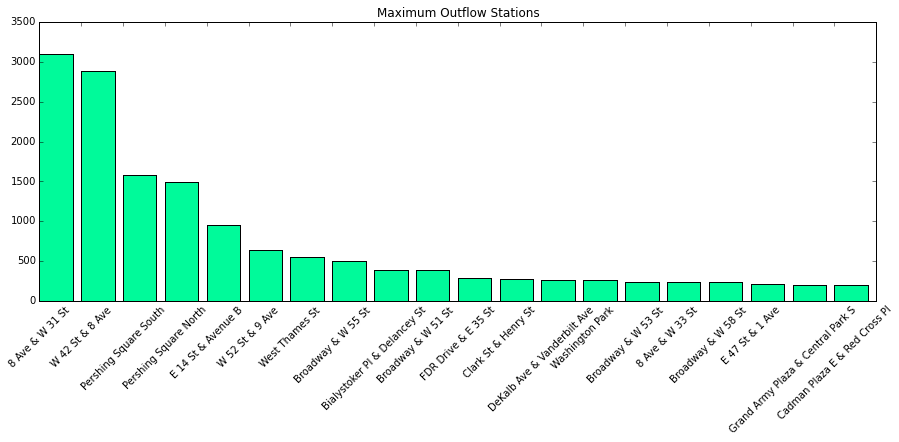

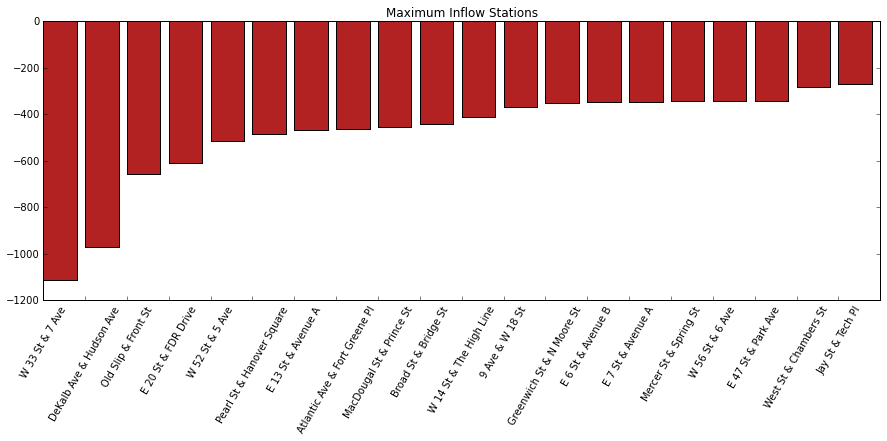

117 East Village 182680
124 Midtown West 178254
115 Chelsea 127920
120 Midtown 126471
122 Midtown South 116436
157 West Village 110135
116 Greenwich Village 107433
109 Lower East Side 92033
158 Flatiron 90030
105 Tribeca 81016


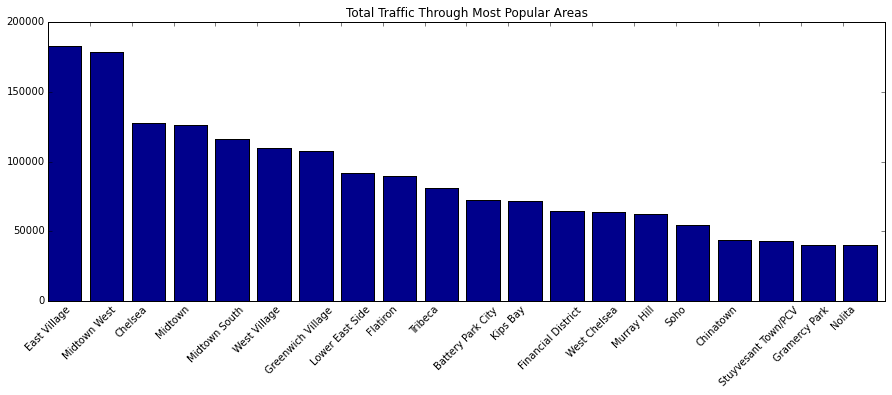

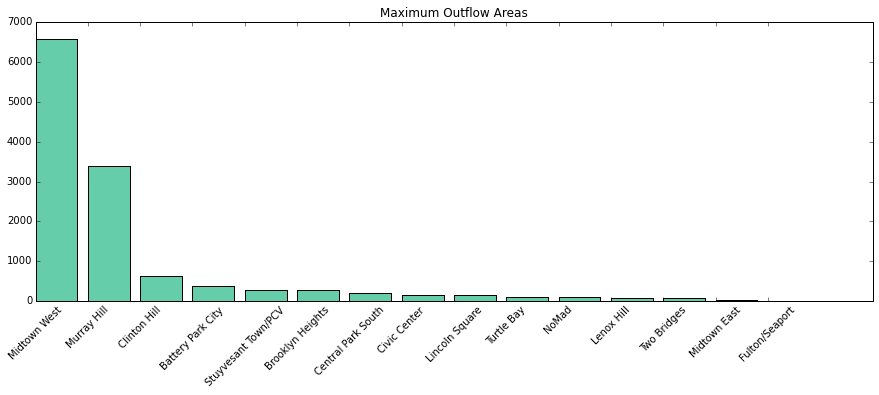

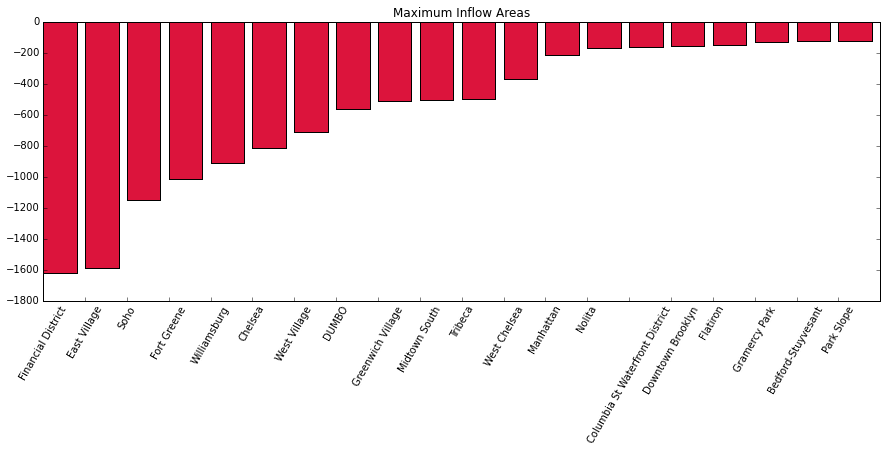

Month:  August 

521, 8 Ave & W 31 St : 25866
293, Lafayette St & E 8 St : 23713
519, Pershing Square North : 23380
426, West St & Chambers St : 23336
497, E 17 St & Broadway : 22057
499, Broadway & W 60 St : 19738
435, W 21 St & 6 Ave : 19680
151, Cleveland Pl & Spring St : 18959
387, Centre St & Chambers St : 18036
285, Broadway & E 14 St : 18020


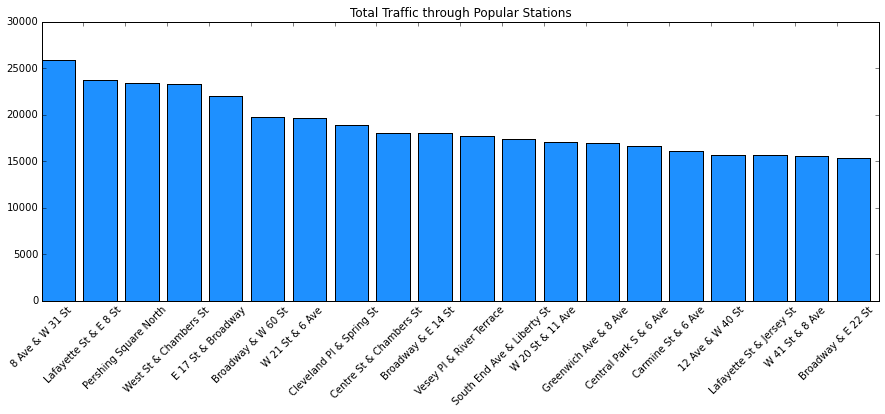

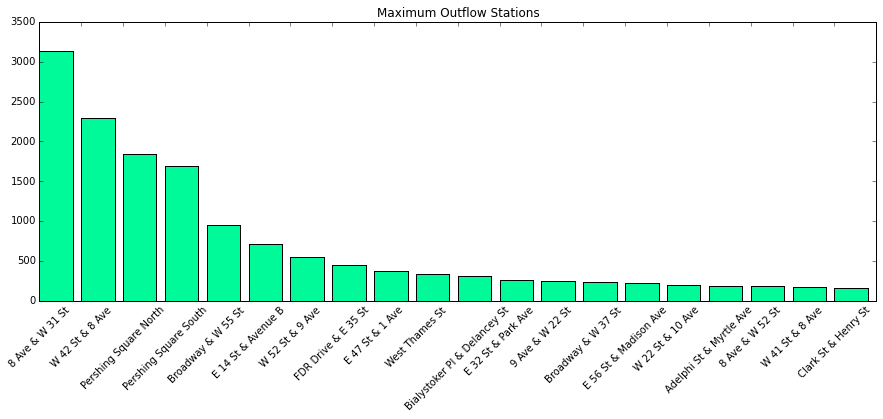

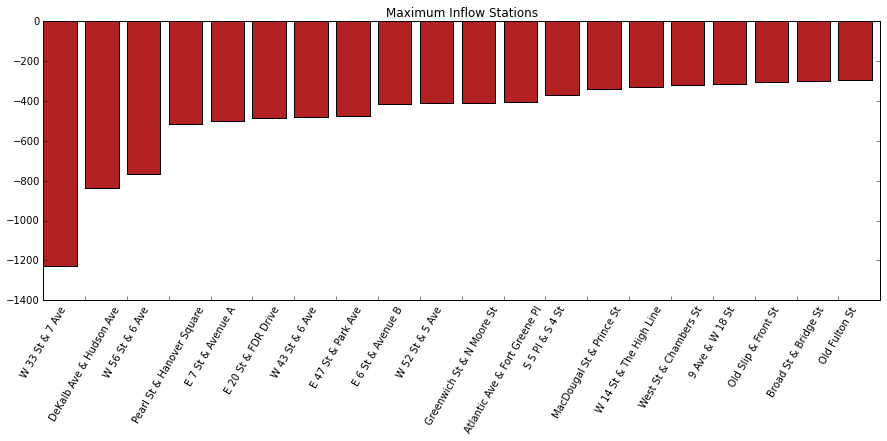

117 East Village 197277
124 Midtown West 187004
115 Chelsea 134470
120 Midtown 133657
122 Midtown South 118997
157 West Village 115772
116 Greenwich Village 112699
158 Flatiron 96943
109 Lower East Side 94602
105 Tribeca 84337


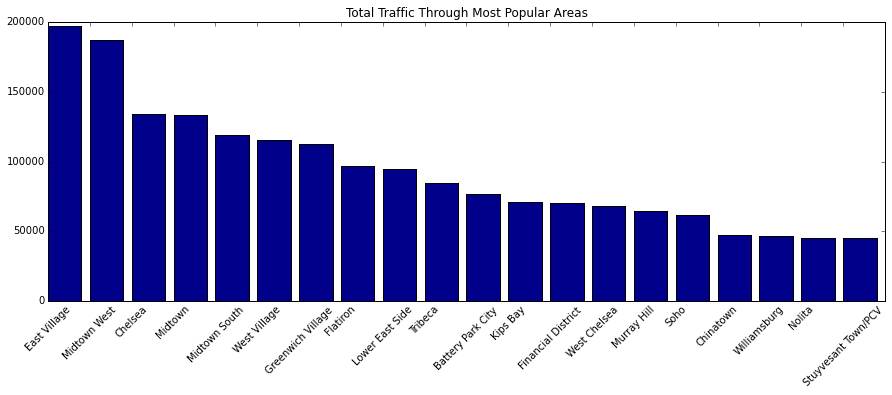

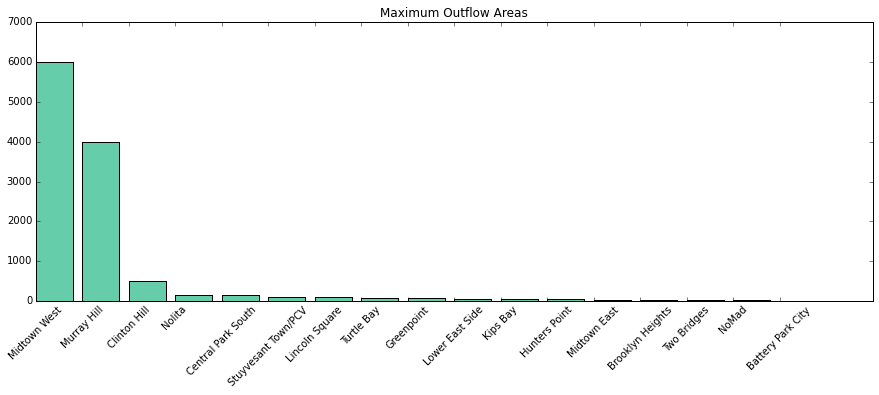

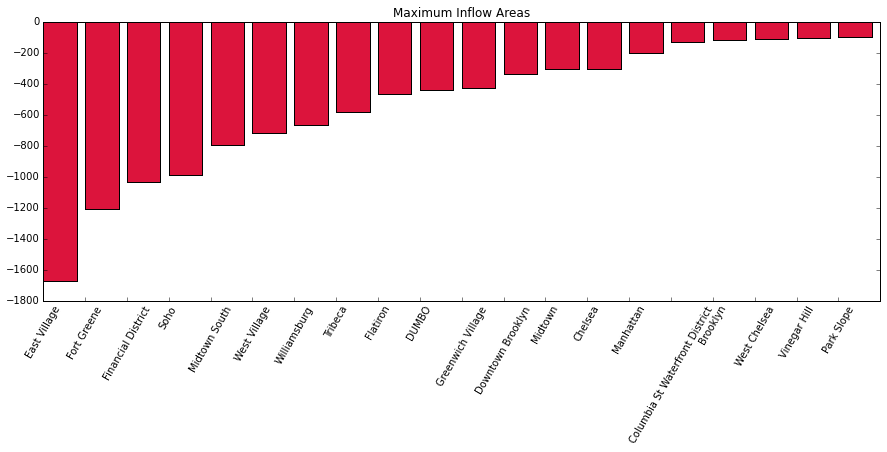

Month:  September 

521, 8 Ave & W 31 St : 26798
519, Pershing Square North : 25930
293, Lafayette St & E 8 St : 22722
426, West St & Chambers St : 21267
435, W 21 St & 6 Ave : 20679
497, E 17 St & Broadway : 20625
151, Cleveland Pl & Spring St : 18298
285, Broadway & E 14 St : 18135
368, Carmine St & 6 Ave : 16945
284, Greenwich Ave & 8 Ave : 16662


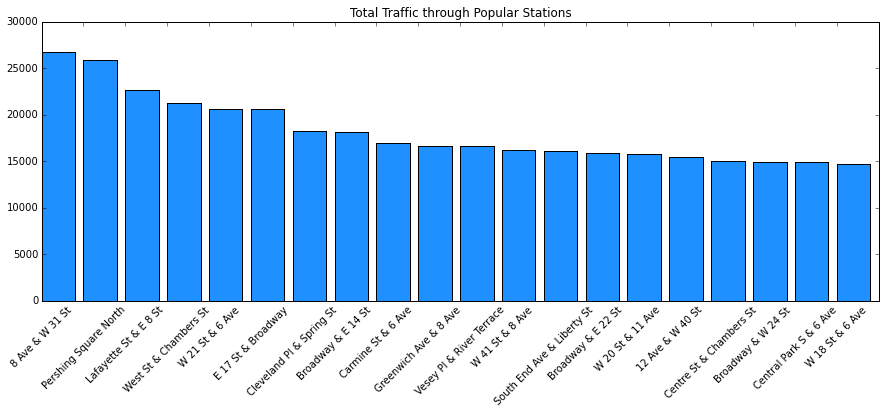

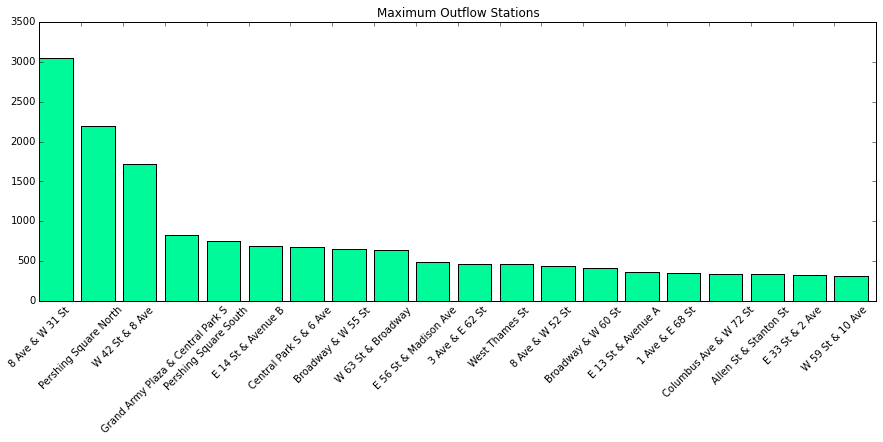

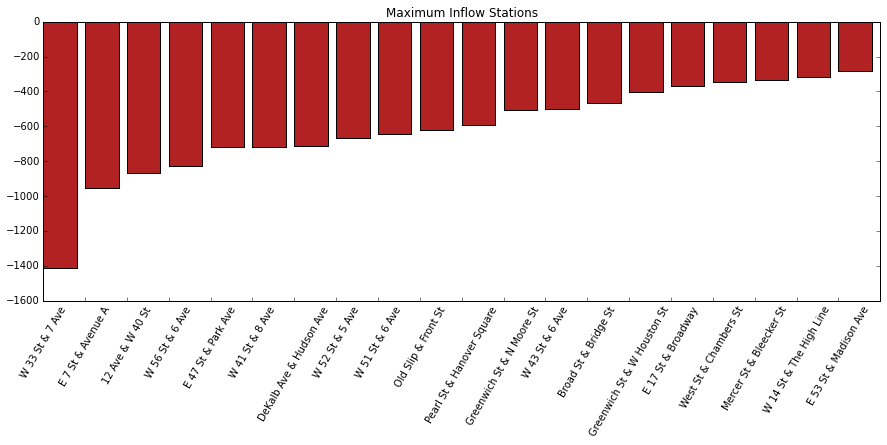

117 East Village 196376
124 Midtown West 186607
120 Midtown 141882
115 Chelsea 140411
116 Greenwich Village 125348
157 West Village 123568
122 Midtown South 116974
109 Lower East Side 95789
158 Flatiron 95538
105 Tribeca 86540


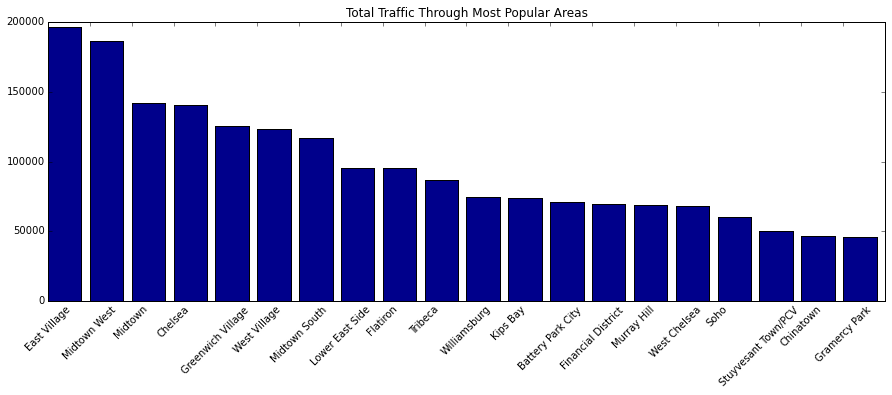

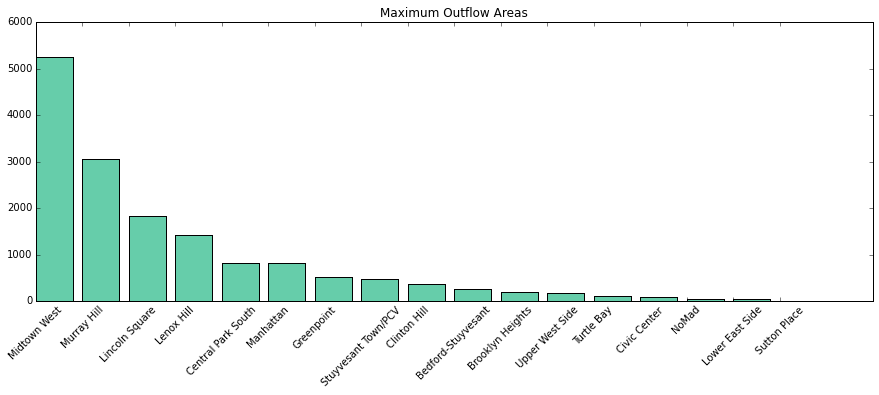

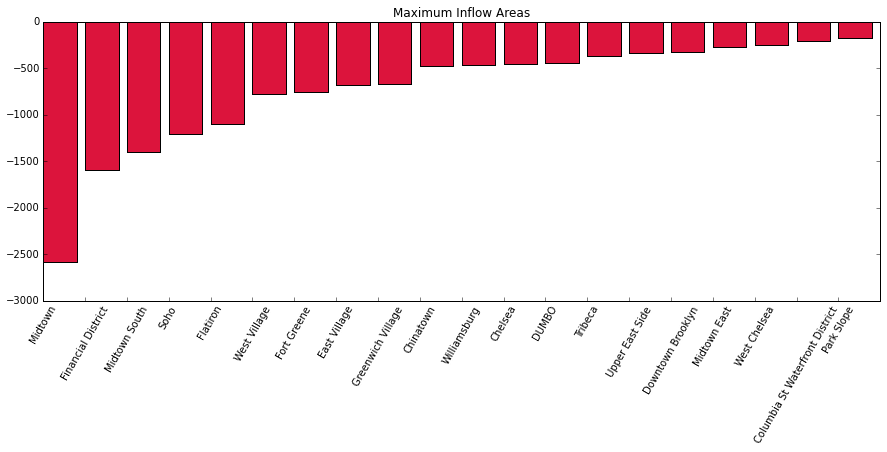

Month:  October 

293, Lafayette St & E 8 St : 22186
519, Pershing Square North : 21575
435, W 21 St & 6 Ave : 20036
497, E 17 St & Broadway : 18745
285, Broadway & E 14 St : 17784
426, West St & Chambers St : 16330
151, Cleveland Pl & Spring St : 15538
368, Carmine St & 6 Ave : 15372
477, W 41 St & 8 Ave : 15181
402, Broadway & E 22 St : 14718


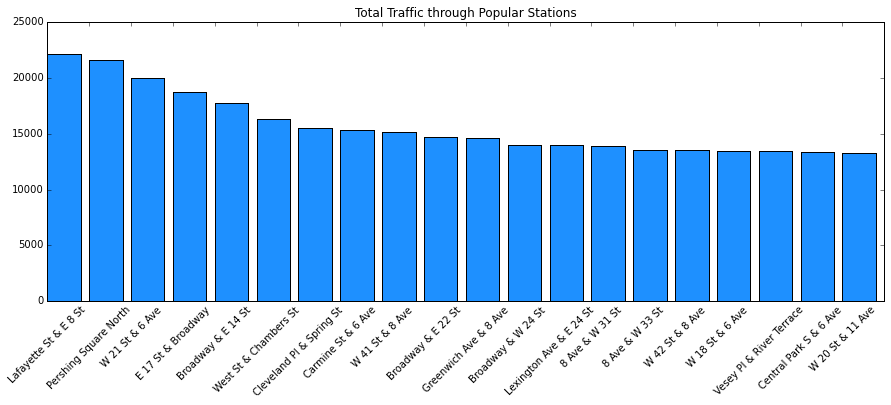

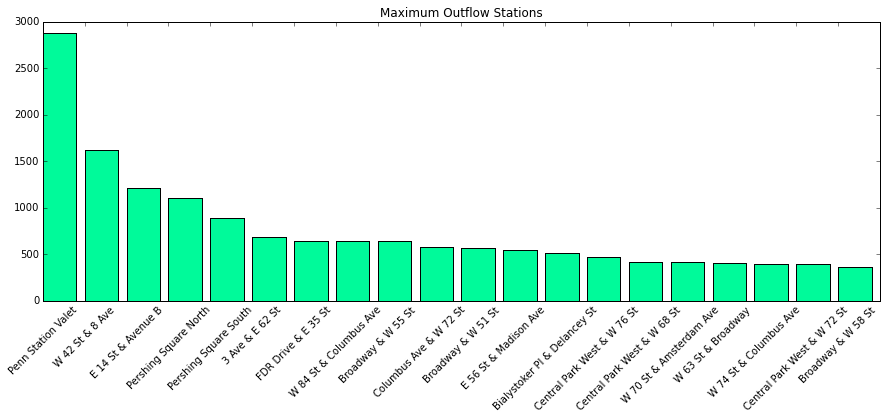

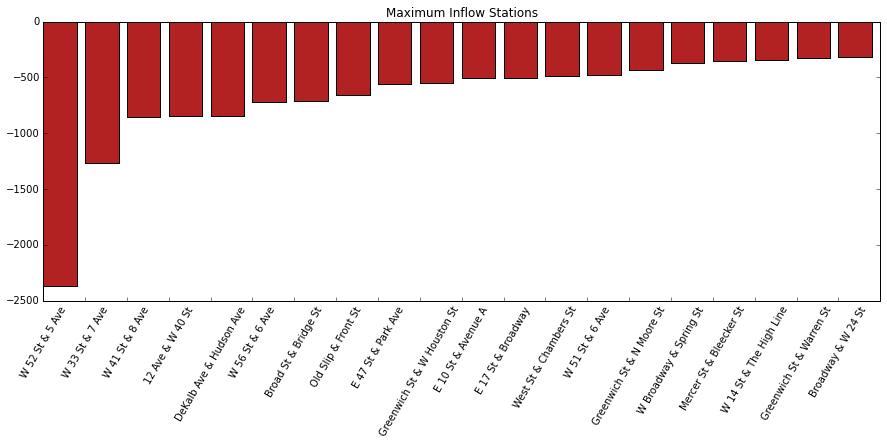

124 Midtown West 177967
117 East Village 177691
120 Midtown 152506
115 Chelsea 130618
122 Midtown South 122224
116 Greenwich Village 116313
157 West Village 107074
158 Flatiron 89020
109 Lower East Side 83060
105 Tribeca 75893


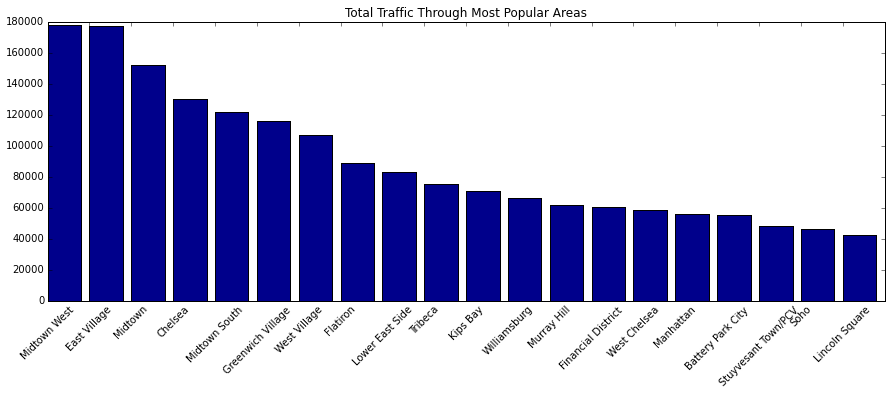

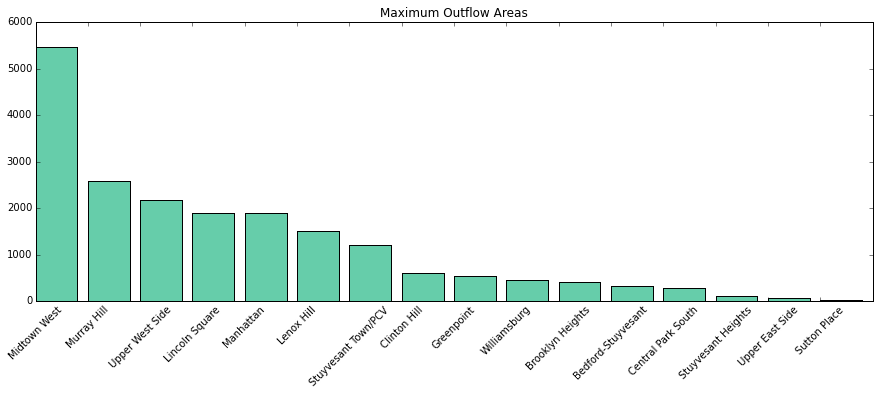

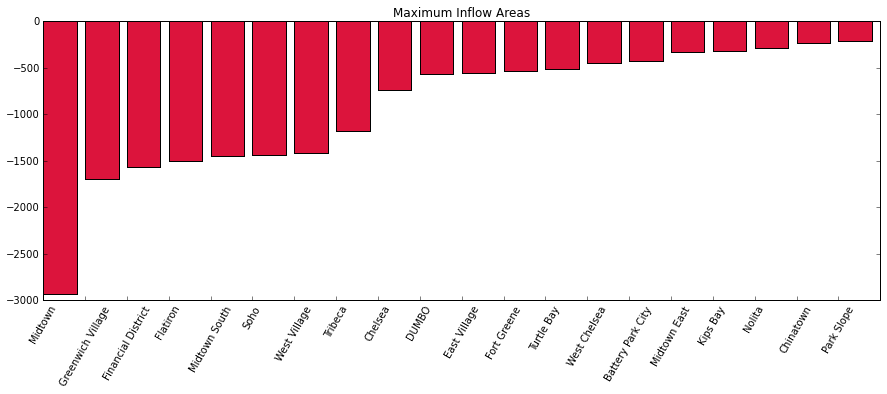

Month:  November 

519, Pershing Square North : 21499
293, Lafayette St & E 8 St : 17657
435, W 21 St & 6 Ave : 16620
497, E 17 St & Broadway : 15765
285, Broadway & E 14 St : 14358
402, Broadway & E 22 St : 12400
368, Carmine St & 6 Ave : 12386
151, Cleveland Pl & Spring St : 12305
426, West St & Chambers St : 12292
477, W 41 St & 8 Ave : 12195


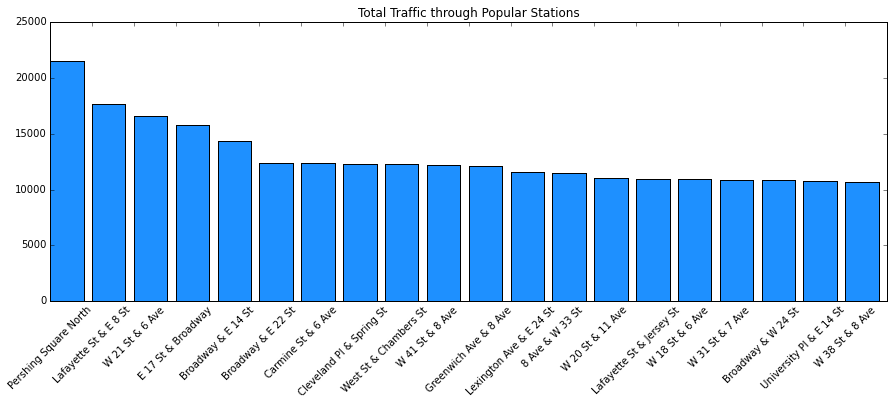

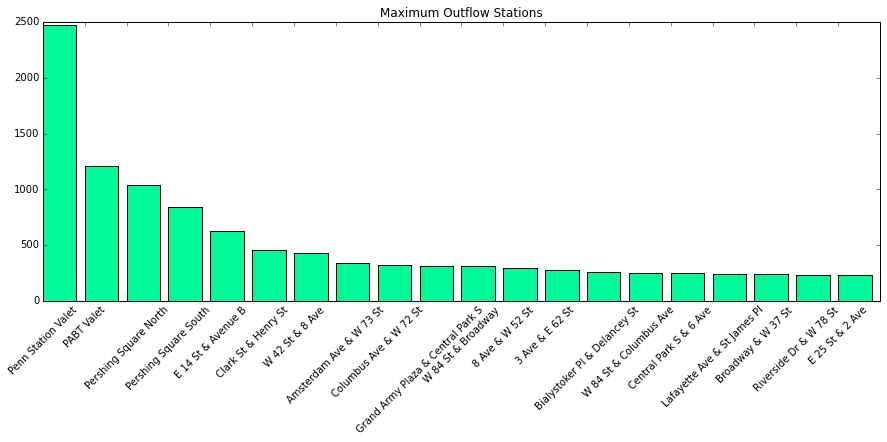

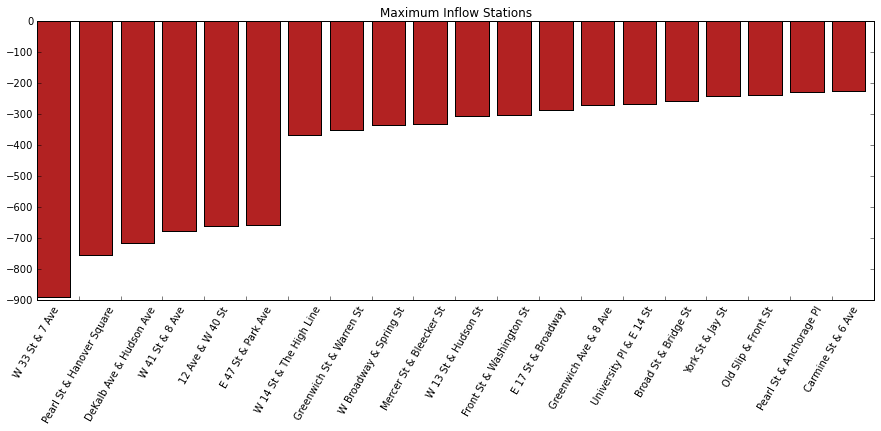

117 East Village 142470
124 Midtown West 137574
120 Midtown 127339
115 Chelsea 107678
122 Midtown South 100803
116 Greenwich Village 96526
157 West Village 86600
158 Flatiron 73476
109 Lower East Side 68403
105 Tribeca 60617


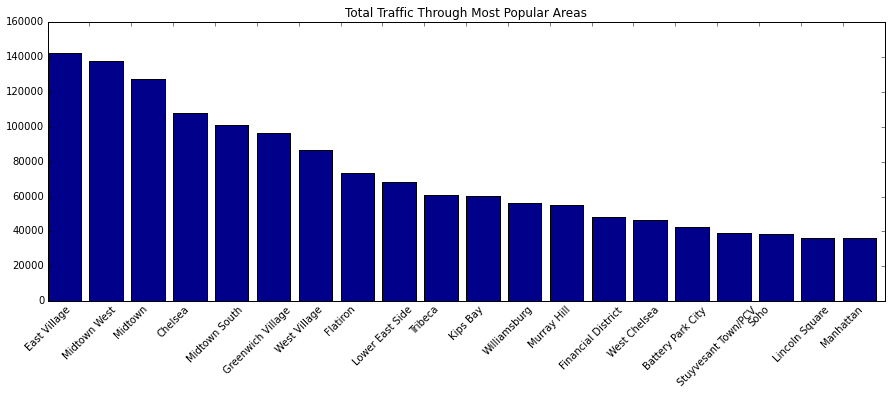

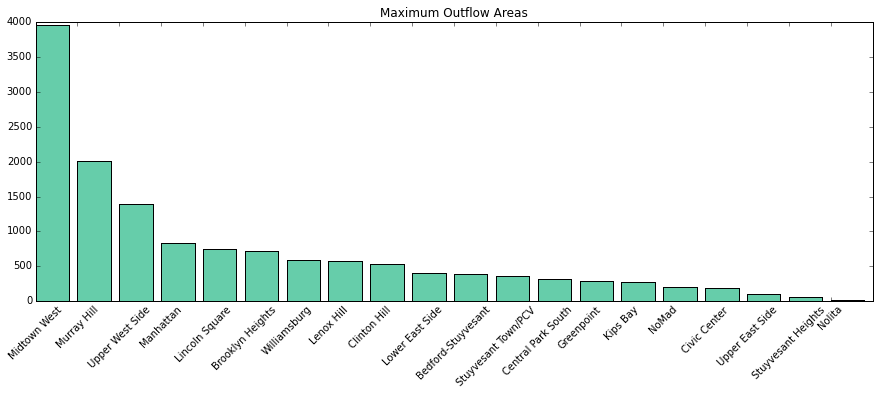

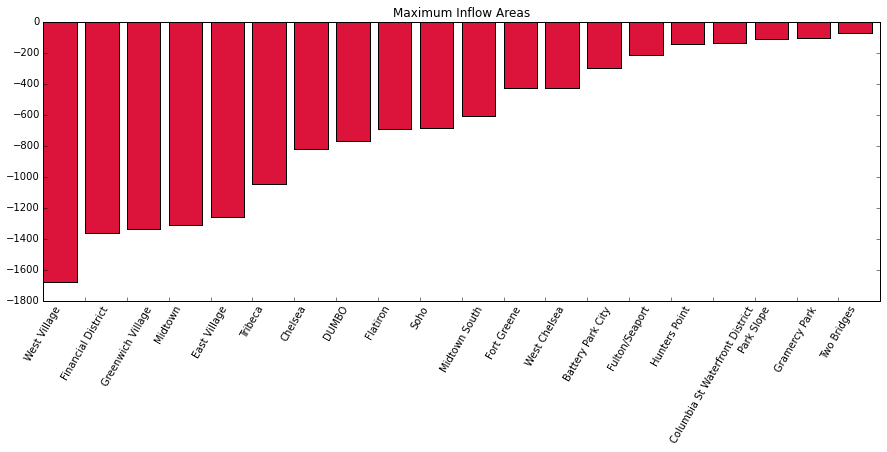

Month:  December 

519, Pershing Square North : 17595
293, Lafayette St & E 8 St : 14353
435, W 21 St & 6 Ave : 13921
497, E 17 St & Broadway : 12865
285, Broadway & E 14 St : 12406
402, Broadway & E 22 St : 11234
490, 8 Ave & W 33 St : 10191
151, Cleveland Pl & Spring St : 9995
368, Carmine St & 6 Ave : 9876
168, W 18 St & 6 Ave : 9783


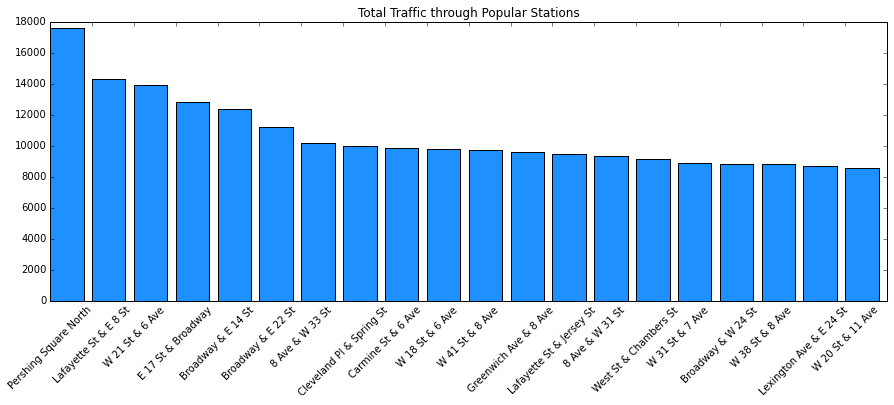

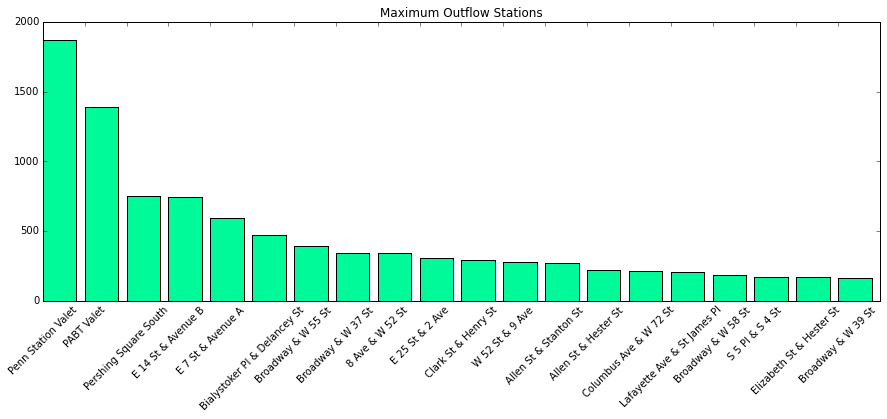

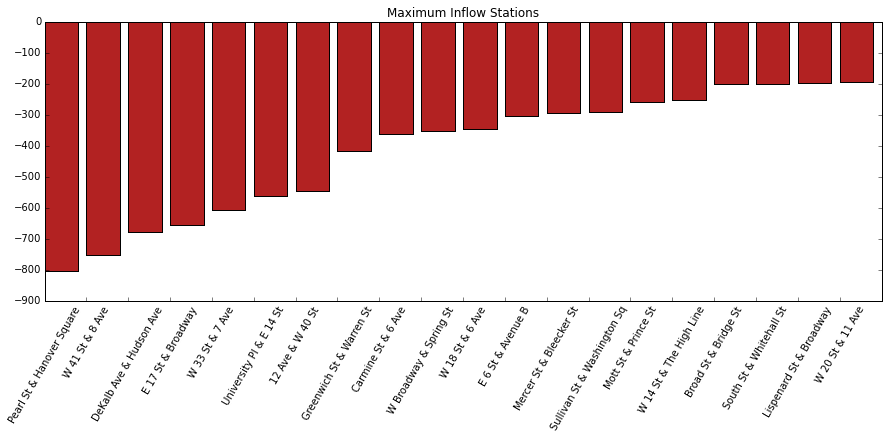

117 East Village 123388
124 Midtown West 109942
120 Midtown 106647
115 Chelsea 88632
122 Midtown South 84259
116 Greenwich Village 76167
157 West Village 68637
158 Flatiron 62234
109 Lower East Side 56496
105 Tribeca 49332


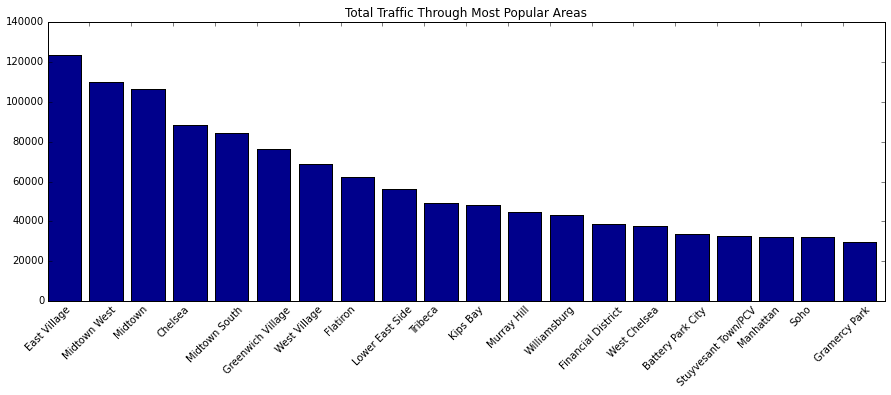

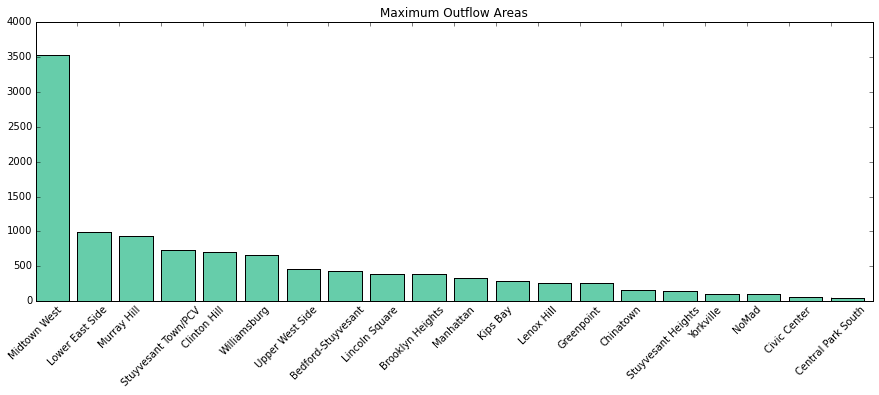

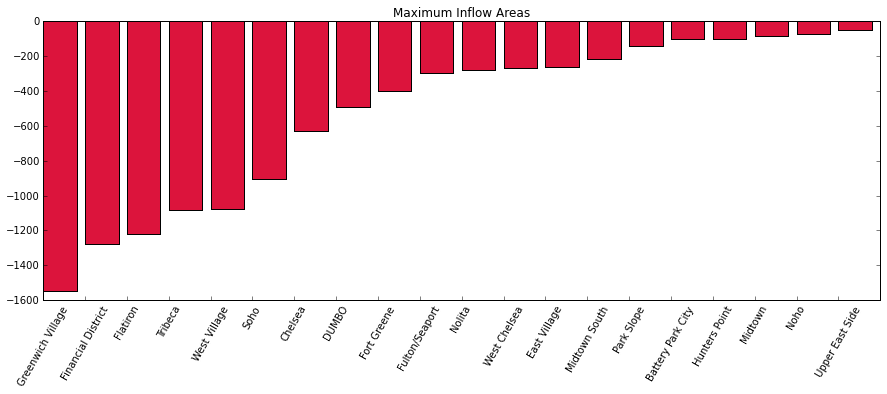

CPU times: user 24.2 s, sys: 404 ms, total: 24.6 s
Wall time: 24.4 s


In [70]:
%%time
for i, month_data in enumerate(trip_data):    
    
    print "Month: ", calendar.month_name[i + 1], "\n"
    
    station_outgoing, station_incoming = trip_stations(month_data)
    station_traffic, popular_stations, station_flow = get_station_traffic(station_outgoing, station_incoming)
    station_outflow, station_inflow = flow_info(station_flow)
    display_station_info(station_traffic, popular_stations, station_outflow, station_inflow)
    
    area_outgoing, area_incoming = get_area_traffic_stations(station_outgoing, station_incoming)
    area_traffic, area_flow = total_area_traffic(area_outgoing, area_incoming)
    popular_areas = get_popular_areas(area_traffic)
    outflow, inflow = flow_info(area_flow)
    display_popular_areas(popular_areas)